In [30]:
import sys
import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor
import numba as nb

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from histo_skim import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
    CUTS,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root" #! BROKEN
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root" #! BROKEN
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root"
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root"

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

In [31]:
ABCD_DPHI = 2.75
ABCD_DTSIZE = 90
WRITE_DATACARDS = False
MIN_MET = 0 # 200
MAX_MET = 999
print(f"{ABCD_DPHI=}\n{ABCD_DTSIZE=}")

ABCD_DPHI=2.75
ABCD_DTSIZE=90


In [32]:
import os
os.uname(), os.uname()[1]

(posix.uname_result(sysname='Linux', nodename='psimmerl-S7P', release='5.15.133.1-microsoft-standard-WSL2', version='#1 SMP Thu Oct 5 21:02:42 UTC 2023', machine='x86_64'),
 'psimmerl-S7P')

In [33]:
N_EVENTS = -1
CUTS = [
    "match",
    "HLT", #! Loading TBranch HLTDecision causes memory overflow so I use second precut TTree
    # "CSC&DT>0",
    "L1",
    "CSCIT",
    "DTIT",
    "MET",
    # "ME11/12",
    "MB1",
    "JET",
    # "MUON",
    # "BDT",
    "HALO",
    # "CSCSIZE",
    "DTSTN",
    "1CSC1DT",
    # "BLINDSR",
    # "DR",
    "DPHI",
]

if "HLT" in CUTS:
    ff_mc, ff_r3 = FN_MC, FN_HLT_R3
else:
    ff_mc, ff_r3 = FN_MC, FN_R3

# **** #

ms_mc = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT IT", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtoot = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT OOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Muon Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Muon Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Jet Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Jet Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)

mss = [ms_mc, ms_r3_dtit]
# mss = [ms_mc, ms_r3_dtoot]
# mss = [ms_mc, ms_r3_dtit, ms_r3_dtoot]

# **** #
print("")
names = [ms.name for ms in mss]
for ims, ms in enumerate(mss):
    # !!! #
    ms.cut = False
    # !!! #
    msn, is_mc = ms.name.lower(), ms.is_mc
    for cut in CUTS:
        match cut:
            case "match":
                if is_mc:
                    ms.match_mc("csc,dt", has_clusters=True)
            case "HLT":
                # if not is_mc:
                #     ms.cut_hlt()
                pass  #! Loading TBranch HLTDecision causes memory overflow so I use a precut TTree
            case "CSC&DT>0":
                ms.f((ms["nCsc"] > 0) & (ms["nDt"] > 0))
            case "L1":
                ms.cut_l1()
            case "CSCIT":
                ms.cut_time("csc", invert="csc oot" in msn)
            case "DTIT":
                ms.cut_time("dt", invert="dt oot" in msn)
            case "MET":
                ms.f((MIN_MET <= ms["met"]) & (ms["met"] < MAX_MET))
            case "ME11/12":
                ms.f(
                    ms["cscNRechitChamberPlus11"]
                    + ms["cscNRechitChamberMinus11"]
                    + ms["cscNRechitChamberPlus12"]
                    + ms["cscNRechitChamberMinus12"]
                    == 0,
                    "csc",
                )
            case "MB1":
                ms.f(ms["dtNHitStation1"] == 0, "dt")
            case "JET":
                # ms.cut_jet("csc,dt")
                ms.cut_jet("csc,dt")#, csc_pt=150, dt_pt=10)
                # ms.cut_jet("dt")
            case "MUON":
                ms.cut_muon("csc,dt")
            case "BDT":
                pass
            case "HALO":
                ms.cut_halo(invert=False)  #! HALO CUT
            case "CSCSIZE":
                # ms.f(ms["cscSize"] > 250, "csc")
                ms.f(ms["cscSize"] > 200, "csc")
            case "DTSIZE":
                ms.f(ms["dtSize"] < 200, "dt")
            case "CSCSTN":
                ms.f(ms["cscSize"] > 250, "csc")
            case "DTSTN":
                ms.f((ms["dtNStation10"] < 3) & ~((ms["dtNStation10"] == 2) & (ms["dtMaxStation"] == 4)), "dt")
            case "1CSC1DT":
                ms.tag(tags="cscdt")
            case "BLINDSR":
                if not is_mc:
                    ms.f((ms["dtSize"] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI), "dt")
            case "DR":
                ms.f(ms["tag_dR"] > 0.5)
            case "DPHI":
                ms.f(ms["tag_dPhi"] > 0.4, invert=False)

    # !!! #
    ms.cut = True
    # !!! #

    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]
    print(f"{ms.name:>{max([len(n) for n in names])}} : {ms.count():,.1f} events")

# **** #
weights = [np.asarray(ms["weight"]) for ms in mss]
colors = [ms.colors[0] for ms in mss]
blind_conds = [
    np.ones_like(ms["tag_dPhi"], dtype=bool) if ms.is_mc else (ms["dtSize"][:, 0] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI)
    for ms in mss
]

Building MuonSystemAwkward 'Signal' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'


  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data, DT IT' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/mds_analysis/data/raw/../processed/r3_hlt569.root'
  Extracted 1,038,214 events

     Signal : 954.4 events
Data, DT IT : 47.0 events


In [34]:
print("min", np.min(mss[0]["met"]), np.min(mss[1]["met"]))
print("max", np.max(mss[0]["met"]), np.max(mss[1]["met"]))
print("median", np.median(mss[0]["met"]), np.median(mss[1]["met"]))
print("mean", np.mean(mss[0]["met"]), np.mean(mss[1]["met"]))
print("std", np.std(mss[0]["met"]), np.std(mss[1]["met"]))
print()

print(np.quantile(mss[0]["met"], [0.1 * i for i in range(1, 10)]))
print(np.quantile(mss[1]["met"], [0.1 * i for i in range(1, 10)]))
print()

print(np.quantile(mss[0]["met"], [1 - (0.01)**(i/10) for i in range(1, 10)]))
print(np.quantile(mss[1]["met"], [1 - (0.01)**(i/10) for i in range(1, 10)]))

min 0.3576166 7.3077397
max 365.18918 75.395744
median 40.882286 32.306156
mean 50.94995549841772 34.249052007147604
std 39.31147341816291 18.067087790663088

[14.7, 21.5, 28.1, 34.2, 40.9, 49.5, 58.8, 73.2, 96.7]
[12.2, 17.5, 22.9, 26.1, 32.3, 34.8, 42.8, 49.8, 63]

[32.4, 49.6, 65.2, 79, 96.7, 119, 137, 155, 188]
[25.6, 34.8, 47.3, 58.5, 63, 63.1, 64, 66.8, 69.6]


In [35]:
met = mss[0]["met"]
# start, end = np.log10(np.quantile(met, 0.0)), np.log10(np.quantile(met, 0.99))
# mids = np.logspace(start, end, 10, endpoint=True)
# start, end = 10**start, 10**end

# start, end = np.quantile(met, 0.005), np.quantile(met, 0.995)
# mids = np.linspace(start, end, 10, endpoint=True)
# mids_str = "[" + ", ".join([f"{x:.2f}" for x in mids]) +"]"
# print(f"{start=:.2f}, {end=:.2f}")
# print(f"{mids_str=}")
# print(f"{sum(met < start)=}, {sum(met > end)=}")

start, end = 0.01, 0.999
mids = np.quantile(met, np.linspace(start, end, 10, endpoint=True))
# start, end = np.log10(start), np.log10(end)
# mids = np.quantile(met, np.logspace(start, end, endpoint=True))
# start, end = 10**start, 10**end
start, end = mids[0], mids[-1]
mids_str = "[" + ", ".join([f"{x:.2f}" for x in mids]) +"]"
print(f"{start=:.2f}, {end=:.2f}")
print(f"{mids_str=}")
print(f"{sum(met < start)=}, {sum(met > end)=}")
print()


start=5.64, end=302.75
mids_str='[5.64, 16.37, 23.33, 30.66, 37.18, 45.97, 55.16, 69.36, 91.93, 302.75]'
sum(met < start)=16, sum(met > end)=2



In [36]:
# # bins, log, norm = [20,0, 5], False, True
# # axis_titles = ["|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# # values = [ms["tag_dR"] for ms in mss]

# # _v, _n, _w, _c = values, names, weights, colors
# # canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# # canvas.Draw()

# # # nbins = int(np.sqrt(mss[-1].count()))
# # # bins, log, norm = [nbins, 0, np.pi, nbins,0, 5], False, True
# # # # bins, log, norm = [10, 0, np.pi, 10,0, 5], False, True
# # # axis_titles = ["|d#phi_{CSC,DT}|", "|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# # # values = [np.c_[ms["tag_dR"],ms["tag_dPhi"]] for ms in mss]

# # # _v, _n, _w, _c = values, names, weights, colors
# # # canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# # # canvas.Draw()

# bins, log, norm = [20,20, 200], False, False
# axis_titles = ["cscJetVetoPt", f"{'fraction of ' if norm else ''}events"]
# values = [ms["cscJetVetoPt"] for ms in mss]

# _v, _n, _w, _c = values, names, weights, colors
# canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# canvas.Draw()

In [37]:
from scipy.optimize import curve_fit, minimize, least_squares

def find_CI_limit(signal, observed, Z=1.65, do_verbose=False):
    """find_CI_limit
    Z=1.65 for 1-sided 95% CI"""

    # def flimit(x):
    #     norm, xe = x[0], np.maximum(np.sqrt(x), 1)
    #     x[0] = x[1]*x[3]/x[2]
    #     xe[0] = x[0] * np.sqrt(np.sum((xe[1:]/x[1:])**2))
    #     # loss = ((norm * sig + x) - obs)/np.sqrt(obse**2 + (norm*sige)**2 + xe**2)
    #     loss = ((norm * sig + x) - obs)/np.sqrt(obse**2)# + (norm*sige)**2)
    #     # loss[0] = ((norm * sig)/np.sqrt((norm*sige)**2 + xe**2) - Z)[0]
    #     loss[0] = ((norm * sig)/np.sqrt(xe**2) - Z)[0]
    #     return loss
    # ##########
    # sig, obs = np.asarray(signal).astype(float), np.asarray(observed).astype(float)
    # sige, obse = np.sqrt(sig), np.sqrt(obs)
    # # sige, obse = sig * 0.2, np.sqrt(obs)
    # ##########
    # p0 = np.array([np.sum(obs)/np.sum(sig), *obs[1:]])
    # bounds = np.asarray([[1e-12, 7*o] for o in obs])
    # bounds[0] = [1e-12, 1.1]
    # bounds = bounds.T
    # ##
    # res = least_squares(flimit, p0, bounds=bounds, ftol=1e-12)
    # print(res.x)
    # norm, pbkg = res.x[0], res.x 
    # pbkg[0] = pbkg[1]*pbkg[3]/pbkg[2]

    # pbkge = np.diag(res.hess_inv.todense())#np.ones_like(pars)
    # pbkge.setflags(write=True)
    # norme, pbkge[0] = pbkge[0], pbkg[0] * np.sqrt(np.sum((pbkge[1:]/pbkg[1:])**2))

    def flimit(x):#, xe):
        norm, x[0] = x[0], x[1]*x[3]/x[2]
        # norme, xe[0] = x[0], x[0] * np.sqrt(np.sum((xe[1:]/x[1:])**2))
        xe = np.maximum(np.sqrt(x), 1)
        norme, xe[0] = 1, x[0] * np.sqrt(np.sum((xe/x)[1:]**2))
        loss = ((norm * sig + x) - obs)/np.sqrt(obse**2 + (norm*sige)**2 + xe**2)
        # loss = ((norm * sig + x) - obs)/np.sqrt(obse**2)
        # loss[0] = ((norm * sig)/np.sqrt((norm*sige)**2 + xe**2) - Z)[0]
        # loss[0] = ((norm * sig)/np.sqrt(xe**2 + (norm*sige)**2) - Z)[0]
        loss_CI = ((norm * sig)/np.sqrt(2*(xe**2) + (norm * sige)**2) - Z)[0]
        # loss_CI = ((norm * sig)/np.sqrt(xe**2) - Z)[0]
        return np.sum(loss**2) + loss_CI**2

    ##########
    sig, obs = np.asarray(signal).astype(float), np.asarray(observed).astype(float)
    sige, obse = np.sqrt(sig), np.sqrt(obs)
    obs[0] = obs[1]*obs[3]/obs[2]
    obse[0] = obs[0] * np.sqrt(np.sum((obse/obs)[1:]))
    # sige, obse = sig * 0.2, np.sqrt(obs)
    ##########
    p0 = np.array([np.sum(obs)/np.sum(sig), *obs[1:]])
    bounds = [(1e-12, 7*o) for o in obs]
    bounds[0] = (1e-12, np.inf)
    ##
    ftol = 1e-12
    res = minimize(flimit, p0, bounds=bounds, tol=ftol)
    # fit_func = lambda x: flimit(x, xe=np.maximum(1,np.sqrt(p0)))
    # for i in range(20):
    #     res = minimize(fit_func, p0, bounds=bounds, tol=ftol)

    p0 = res.x
    pe = np.diag(res.hess_inv.todense())#np.ones_like(pars)
    pe = np.sqrt(max(1, abs(res.fun)) * ftol * pe)
    # fit_func = lambda x: flimit(x, xe=pe)

    norm, pbkg = res.x[0], res.x 
    pbkge = np.diag(res.hess_inv.todense())#np.ones_like(pars)
    pbkge = np.sqrt(max(1, abs(res.fun)) * ftol * pbkge)
    norme = pbkge[0]

    pbkge.setflags(write=True)
    pbkg[0] = pbkg[1]*pbkg[3]/pbkg[2]
    pbkge[0] = pbkg[0] * np.sqrt(np.sum((pbkge/pbkg)[1:]**2))

    if do_verbose:
        print("|   |    Obs | FitBkg |    Sig |")
        print("|---+--------+--------+--------+")
        print(f"| A | {obs[0]:6.2f} | {pbkg[0]:6.2f} | {norm*sig[0]:6.2f} |")
        print(f"| B | {obs[1]:6.2f} | {pbkg[1]:6.2f} | {norm*sig[1]:6.2f} |")
        print(f"| C | {obs[2]:6.2f} | {pbkg[2]:6.2f} | {norm*sig[2]:6.2f} |")
        print(f"| D | {obs[3]:6.2f} | {pbkg[3]:6.2f} | {norm*sig[3]:6.2f} |")
        print(f"Limit = {100*norm:.3f}%")
    # print(norm, norme, pbkg, pbkge)
    return norm, pbkg, norme, pbkge

In [38]:
def calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind=False, g_cond=None):
    if g_cond is not None:
        a_cond, b_cond = a_cond & g_cond, b_cond & g_cond
        c_cond, d_cond = c_cond & g_cond, d_cond & g_cond
    a = 0 if blind else np.sum(weight[a_cond])
    b = np.sum(weight[b_cond])
    c = np.sum(weight[c_cond])
    d = np.sum(weight[d_cond])
    ae, be, ce, de = np.sqrt(a), np.sqrt(b), np.sqrt(c), np.sqrt(d)
    pa, pae = 0, 0

    if b * c * d > 0:
        pa, pae = b * d / c, b * d / c * ((be / b) ** 2 + (ce / c) ** 2 + (de / d) ** 2) ** 0.5
    return (pa,a,b,c,d), (pae,ae,be,ce,de)

# SIGNAL IN ABCD REGION A
abcd_sig, abcd_obs = [], []
print("SR Background Predictions from ABCD")
for ims, ms in enumerate(mss):
    dtsize, dphi = ms["dtSize"][:,0], ms["tag_dPhi"]
    a_cond = (dtsize > ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    b_cond = (dtsize < ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    c_cond = (dtsize < ABCD_DTSIZE) & (dphi < ABCD_DPHI)
    d_cond = (dtsize > ABCD_DTSIZE) & (dphi < ABCD_DPHI)
    vals, errs = calc_abcd(ms["weight"], a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())
    tot, a, ae, pa, pae = np.sum(vals[2:]), vals[1], errs[1], vals[0], errs[0]

    if ims == 0:
        abcd_sig = list(vals[1:5])
        asig = vals[1]
    elif ims == 1:
        abcd_obs = list(vals[1:5])
        abcd_obs[0] = vals[0]

    print(f"{ms.name}:")#:>{max([len(n) for n in names])}} :")
    print(f"\ta = " +(f"{vals[1]:4.2f} ± {errs[1]:4.2f}" if ms.is_mc else f"{vals[0]:4.2f} ± {errs[0]:4.2f} (b*d/c)"))
    print(f"\tb = {vals[2]:4.2f} ± {errs[2]:4.2f}")
    print(f"\tc = {vals[3]:4.2f} ± {errs[3]:4.2f}")
    print(f"\td = {vals[4]:4.2f} ± {errs[4]:4.2f}")

sig, obs = np.asarray(abcd_sig), np.asarray(abcd_obs)
lm, pp, le, pe = find_CI_limit(sig, obs, do_verbose=True)
pae = pp[0] * np.sqrt(np.sum((np.sqrt(pp[1:])/pp[1:])**2))
print(lm, pp, le, pe, pae)
# assert np.sum(np.abs(obs - (lm*sig + pp))[1:]) < 1e-4

SR Background Predictions from ABCD
Signal:
	a = 313.52 ± 17.71
	b = 202.37 ± 14.23
	c = 138.34 ± 11.76
	d = 291.78 ± 17.08
Data, DT IT:
	a = 0.44 ± 0.46 (b*d/c)
	b = 1.00 ± 1.00
	c = 32.00 ± 5.66
	d = 14.00 ± 3.74
|   |    Obs | FitBkg |    Sig |
|---+--------+--------+--------+
| A |   0.44 |   0.00 |   0.75 |
| B |   1.00 |   0.00 |   0.48 |
| C |  32.00 |  32.31 |   0.33 |
| D |  14.00 |  12.63 |   0.70 |
Limit = 0.239%
0.002389419561845037 [3.90956572e-13 1.00000000e-12 3.23129849e+01 1.26329738e+01] 2.875591466023694e-07 [1.91583689e-04 4.90038288e-04 8.00252958e-05 7.26167460e-04] 3.9095657196621435e-07


In [39]:
le/lm, pe/pp, "|", pae/pe[0], pae/pp[0]

(0.00012034686213932432,
 array([4.90038288e+08, 4.90038288e+08, 2.47656774e-06, 5.74819098e-05]),
 '|',
 0.002040656872862264,
 1000000.000000055)

In [40]:
print(f"""# norm {10**int(np.log10(5/sum(abcd_sig)))}
# ABCD_DPHI {ABCD_DPHI}
# ABCD_SIZE {ABCD_DTSIZE}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {abcd_obs[0]:.3f} \t {abcd_obs[1]:.3f} \t {abcd_obs[2]:.3f} \t {abcd_obs[3]:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {abcd_sig[0]:.3f} \t 1 \t {abcd_sig[1]:.3f} \t 1 \t {abcd_sig[2]:.3f} \t 1 \t {abcd_sig[3]:.3f} \t 1
------------------------------
single_A \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B,single_C,single_D
single_B \t rateParam \t chB \t bkg \t {abcd_obs[1]:.3f} \t [0,{7*abcd_obs[1]:.3f}]
single_C \t rateParam \t chC \t bkg \t {abcd_obs[2]:.3f} \t [0,{7*abcd_obs[2]:.3f}]
single_D \t rateParam \t chD \t bkg \t {abcd_obs[3]:.3f} \t [0,{7*abcd_obs[3]:.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
""")

# norm 0.01
# ABCD_DPHI 2.75
# ABCD_SIZE 90
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	 0.438 	 1.000 	 32.000 	 14.000
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 sig 	 bkg 	 sig 	 bkg 	 sig 	 bkg 	 sig 	 bkg
process 	 0 	 1 	 0 	 1 	 0 	 1 	 0 	 1
rate 	 313.524 	 1 	 202.371 	 1 	 138.337 	 1 	 291.777 	 1
------------------------------
single_A 	 rateParam 	 chA 	 bkg 	 (@0*@2/@1) 	 single_B,single_C,single_D
single_B 	 rateParam 	 chB 	 bkg 	 1.000 	 [0,7.000]
single_C 	 rateParam 	 chC 	 bkg 	 32.000 	 [0,224.000]
single_D 	 rateParam 	 chD 	 bkg 	 14.000 	 [0,98.000]
norm rateParam * sig 1
single_lumi 	 lnN 	 1.2 	 - 	 1.2 	 - 	 1.2 	 - 	 1.2 	 -



NEV_SMEAR=100,000
0 39 0.6040899157524109 0.6040899157524109
1 39 0.40224552154541016 3.141534749661581
2 36 50.0 200
0 6 1.0 1.0
1 6 0.4168292284011841 3.0339582006083887
1 0.7871658289704646
2 6 51.0 200
2 0.031085172555103076
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =     0.697643
Chi2                      =      1.39529
NDf                       =            4
Edm                       =  2.63558e-06
NCalls                    =           37
Constant                  =      3.22893   +/-   0.324628    
Slope                     =    -0.787166   +/-   0.219501    
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      3.10094
Chi2                      =      6.20188
NDf                       =            4
Edm                       =  2.23651e-06
NCalls                    =           45
Constant                  =      5.16796   +/-   0.473918    
Slope                     =   -0.

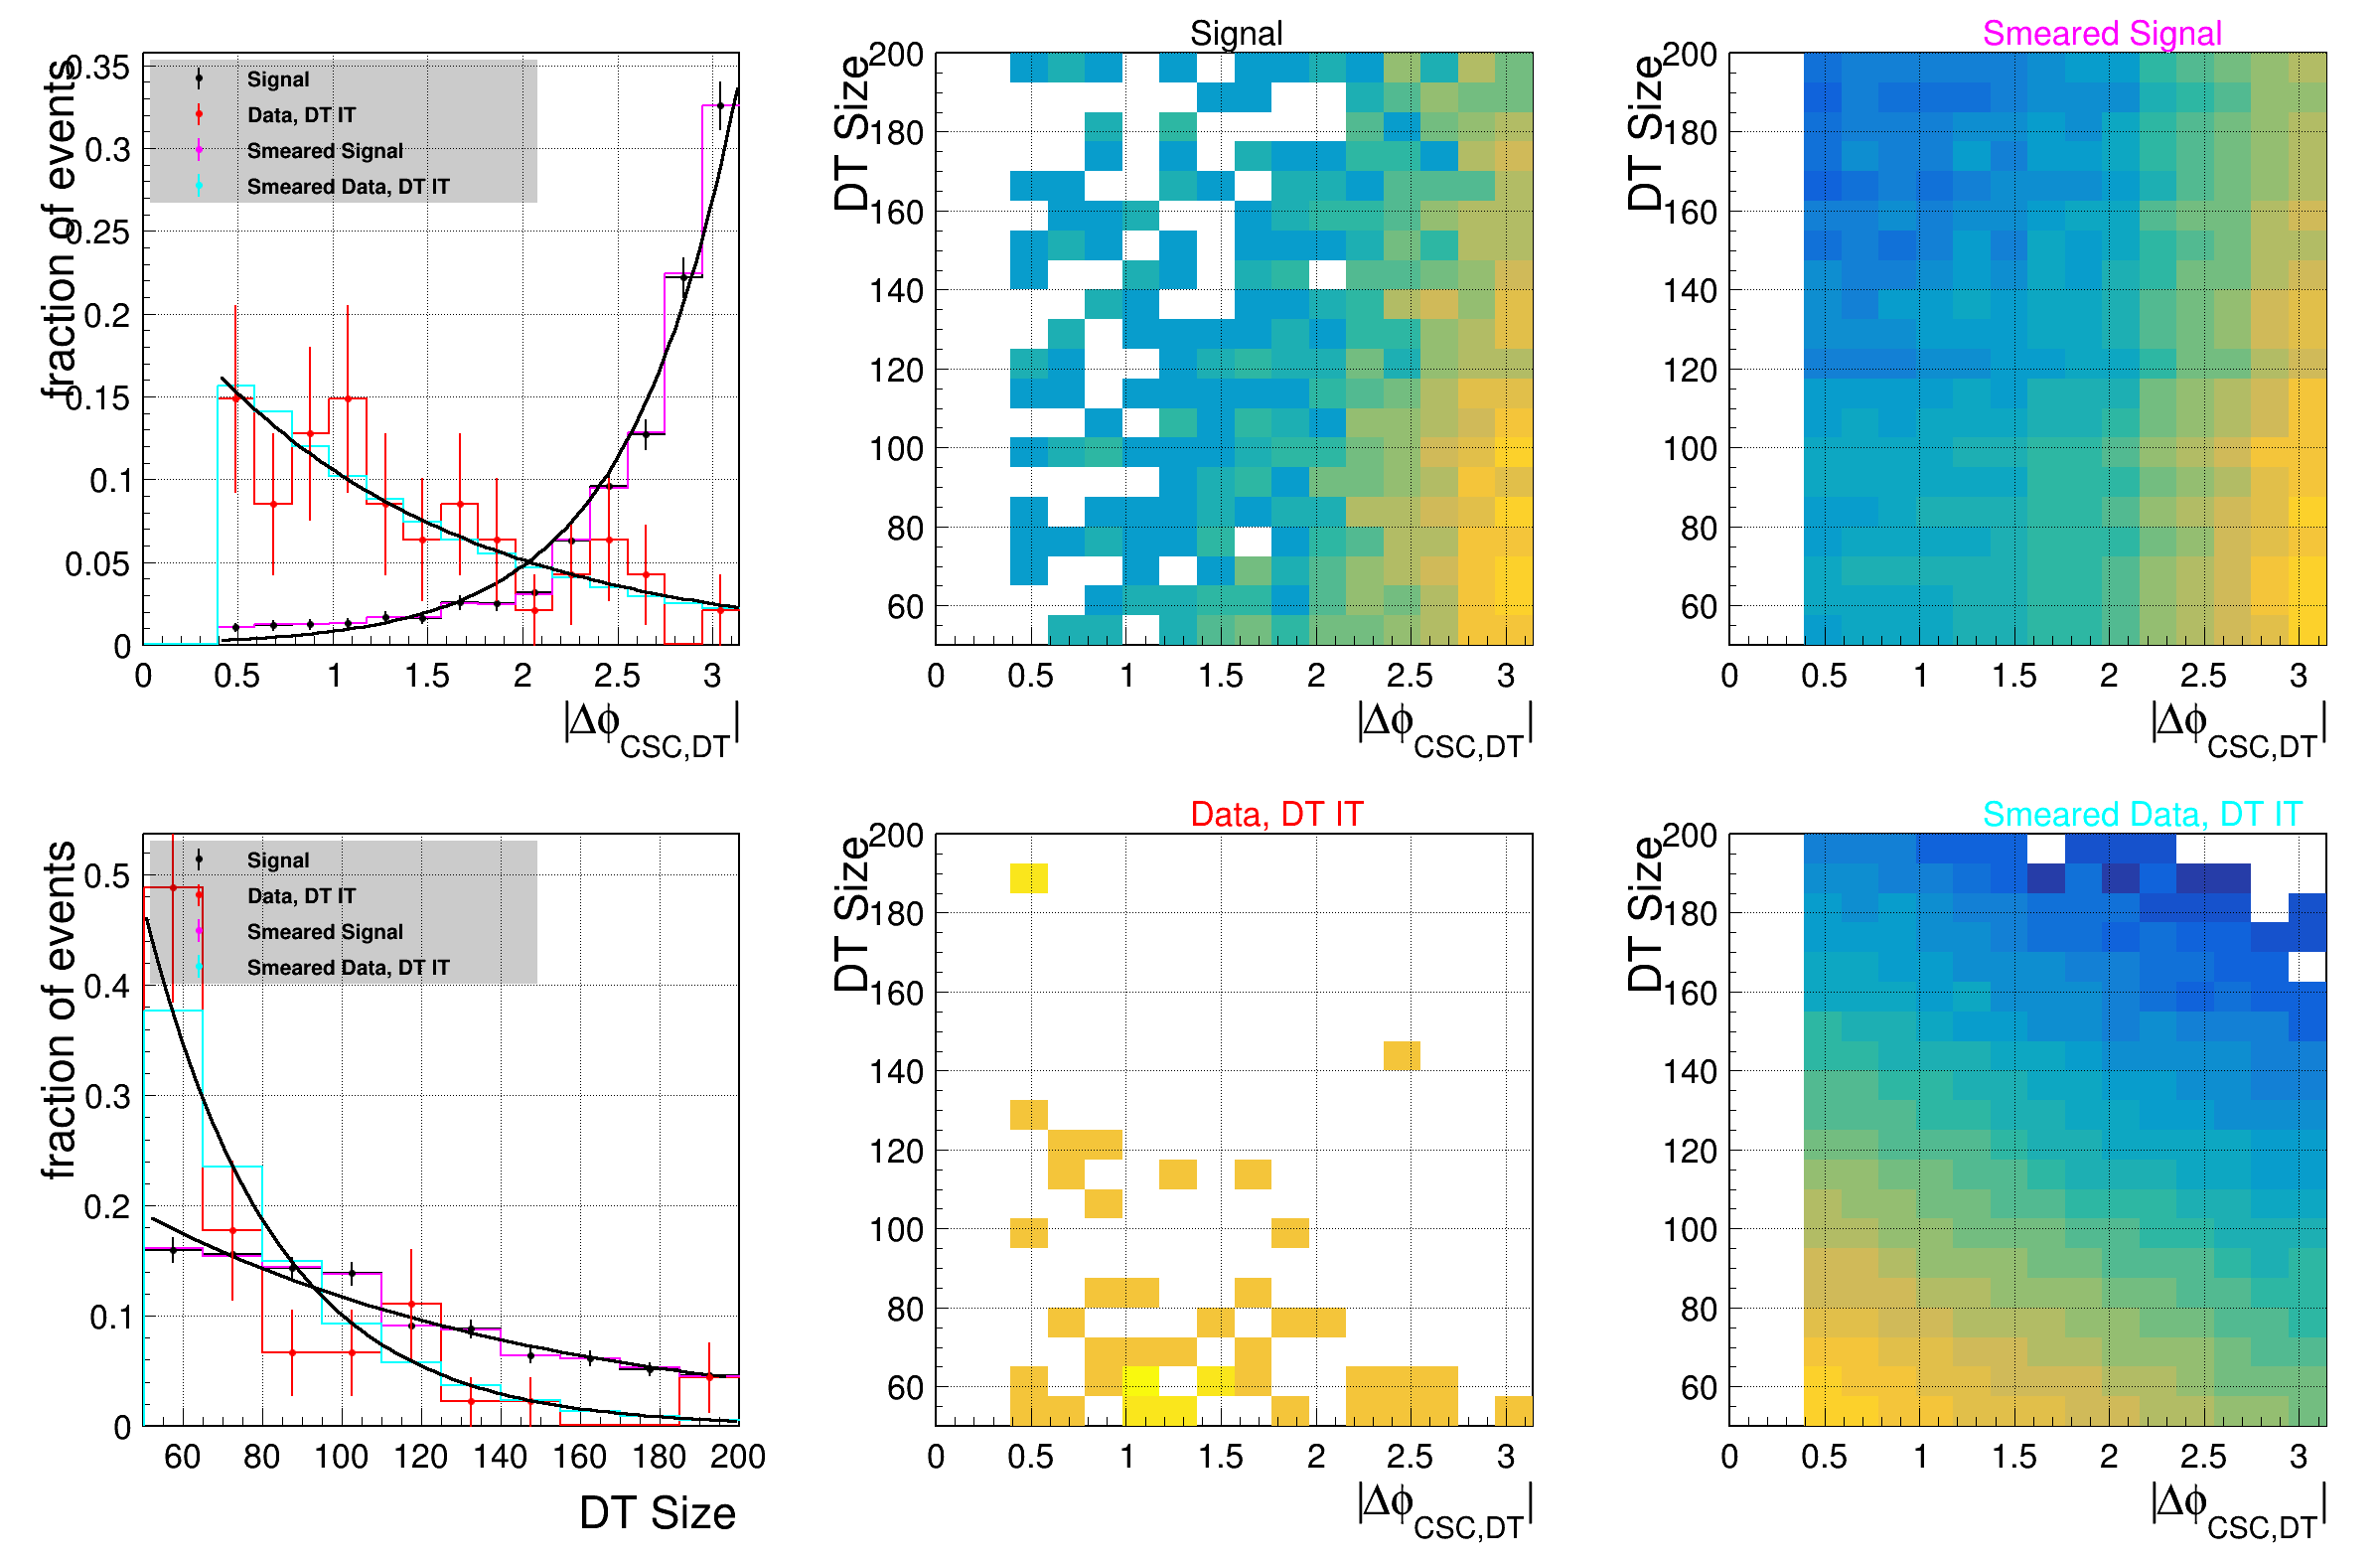

In [41]:
fits = []
def smear(*args, fit=False, bootstrap=True, size=None):
    nev = args[0].shape[0]
    # if not bootstrap and size is None:
    #     return [arg if i != 2 else np.random.normal(arg, np.sqrt(arg)) for i, arg in enumerate(args)]

    if size is None:
        size = nev
    elif size < 1000:
        size = size * nev
    size = int(size)

    if bootstrap:
        idxs = np.random.randint(0, nev, size)
    else:
        idxs = np.arange(0, size) % nev

    out = []
    for i, arg in enumerate(args):
        # nbin = max(10, int(np.sqrt(arg.shape[0])))
        # nbin = floor(np.sqrt(arg.shape[0]))
        # _min, _max = np.quantile(arg, [0.1, 0.9])
        # _min, _max = np.quantile(arg, [0.2, 0.8])
        # _min, _max = np.quantile(arg, [0.16, 0.84]) # ~ +/- 1 sigma
        # _min, _max = np.quantile(arg, [0.05, 0.95]) # 90%
        _min, _max = np.quantile(arg, [0.00, 1.00]) # 90%
        _max = min(_max, 200)
        nbin = int(np.sqrt(np.sum((_min <= arg) & (arg <= _max))))
        print(i, nbin, _min, _max)

        RAND_NUM = f"{np.random.randint(999999999)}"
        ft = rt.TF1("fit_"+RAND_NUM, "expo", _min, _max)
        hh = rt.TH1D("hh_"+RAND_NUM, "", nbin, _min, _max)

        if i == 0:
            out.append(arg[idxs] * nev / size)
        elif i == 1:
            _out = np.array([])
            if fit:
                # ft = rt.TF1("fit_df", "expo", 0.4, np.pi)
                # hh = rt.TH1D("", "", nbin, 0.4, np.pi)
                flip = np.mean(arg) > (np.pi - 0.4) * 3/4
                # print(flip, np.mean(arg), _min, _max)
                for x in arg:
                    hh.Fill(x)
                # hh.Fit("fit_df", "RL")
                hh.Fit("fit_"+RAND_NUM, "RL")
                ww = np.abs(ft.GetParameter(1))
                print(i, ww)
                while len(_out) < size:
                    if flip:
                        _temp = np.pi - np.random.exponential(1 / ww, size)
                    else:
                        _temp = np.random.exponential(1 / ww, size) + 0.4
                    _out = np.append(_out, _temp[(0.4 < _temp) & (_temp < np.pi)])
            else:
                if bootstrap:
                    idxs = np.random.randint(0, nev, size)
                    # out.append(arg[idxs])
                    _out = arg[idxs]
                    # while len(_out) < size:
                    #     _temp = np.pi - np.random.exponential(1/1.76736e+00, size)
                    #     _out = np.append(_out, _temp[_temp >= 0.4])
            out.append(_out[:size])
        elif i == 2:
            if fit:
                # ft = rt.TF1("fit_sz", "expo", 50, _max)
                # hh = rt.TH1D("", "", nbin, 50, _max)
                for x in arg:
                    hh.Fill(x)
                # hh.Fit("fit_sz", "RL")
                hh.Fit("fit_"+RAND_NUM, "RL")
                ww = np.abs(ft.GetParameter(1))
                print(i, ww)
                out.append(np.random.exponential(1 / ww, size) + 50)
            else:
                if bootstrap:
                    idxs = np.random.randint(0, nev, size)
                    # out.append(np.random.normal(arg[idxs], np.sqrt(arg[idxs])))
                    out.append(arg[idxs])
                    # out.append(np.random.exponential(1/1.21694e-02, size) + 50)
        else:
            out.append(arg[idxs])
        fits.append(ft)

    return out

# *** #

NEV_SMEAR = max([100_000] + [w.shape[0] for w in weights])
print(f"{NEV_SMEAR=:,.0f}")

# values = [[np.asarray(ms["weight"]), np.asarray(ms["tag_dPhi"]), np.asarray(ms["dtSize"][:, 0])] for ms in mss]
values = []
for ms in mss:
    wt, df, sz = np.asarray(ms["weight"]), np.asarray(ms["tag_dPhi"]), np.asarray(ms["dtSize"][:,0])
    # if not ms.is_mc:
    #     wt, df, sz = wt[sz < 200], df[sz < 200], sz[sz < 200] 
    values.append([wt, df, sz])

values_smeared = [smear(*vs, fit=iv > 0, bootstrap=True, size=NEV_SMEAR) for iv, vs in enumerate(values)]

_w = [vs[0] for vs in values + values_smeared]
_df = [vs[1] for vs in values + values_smeared]
_sz = [vs[2] for vs in values + values_smeared]
_n = names + ["Smeared " + n for n in names]
_c = colors + [c + 5 for c in colors]

# *** #

_v = _df
# bins, log, norm = [32, 0, np.pi], False, True
bins, log, norm = [16, 0, np.pi], False, True
axis_titles = ["|#Delta#phi_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
c_df, leg_df, hs_df = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

_v = _sz
# bins, log, norm = [20, 50, 200], False, True
bins, log, norm = [10, 50, 200], False, True
axis_titles = ["DT Size", f"{'fraction of ' if norm else ''}events"]
c_sz, leg_sz, hs_sz = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

_v = [np.c_[df, sz] for df, sz in zip(_df, _sz)]
bins, log, norm = [16, 0, np.pi, 20, 50, 200], False, True
axis_titles = ["|#Delta#phi_{CSC,DT}|", "DT Size", f"{'fraction of ' if norm else ''}events"]
c_2d, leg_2d, hs_2d = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# *** #

fit_sig_df = rt.TF1("fit_sig_df", "expo", 0.4, np.pi)
hs_df[0].Fit("fit_sig_df", "RL")

fit_bkg_df = rt.TF1("fit_bkg_df", "expo", 0.4, np.pi)
hs_df[1].Fit("fit_bkg_df", "RL")

fit_sig_sz = rt.TF1("fit_sig_sz", "expo", 50, 500)
hs_sz[0].Fit("fit_sig_sz", "RL")

fit_bkg_sz = rt.TF1("fit_bkg_sz", "expo", 50, 200)
hs_sz[1].Fit("fit_bkg_sz", "RL")

# *** #

RAND_NUM = f"{np.random.randint(999999999)}"
canvas = rt.TCanvas("c" + RAND_NUM, "c" + RAND_NUM, 3 * 800, 2 * 800)
canvas.Divide(3, 2)

canvas.cd(1)
canvas.cd(1).SetGrid()
canvas.cd(1).SetRightMargin(0.04)
for h in hs_df:
    h.Draw("same hist")
hs_df[0].Draw("same func")
hs_df[1].Draw("same func")
leg_df.Draw()

canvas.cd(4)
canvas.cd(4).SetGrid()
canvas.cd(4).SetRightMargin(0.04)
for h in hs_sz:
    h.Draw("same hist")
hs_sz[0].Draw("same func")
hs_sz[1].Draw("same func")
leg_sz.Draw()

lat = rt.TLatex()
for ic, ih in [[2, 0], [5, 1], [3, 2], [6, 3]]:
    canvas.cd(ic)
    canvas.cd(ic).SetGrid()
    canvas.cd(ic).SetRightMargin(0.04)
    canvas.cd(ic).SetLogz()
    hs_2d[ih].Draw("col")
    lat.SetTextColor(hs_2d[ih].GetLineColor())
    lat.DrawLatexNDC(0.5, 0.96, hs_2d[ih].GetName().split(".")[0])

canvas.Draw()

# n_shift, qt = max([len(n) for n in _n]), 0.95
# print(f"Max Quantile = {qt}")
# for n, df, sz in zip(_n, _df, _sz):
#     print(f"{n:>{n_shift}}: {np.mean(sz)}, dtSize = {np.quantile(sz, qt):3.0f}")

0 779.8724
1 46.0
2 174.58228
3 1.0


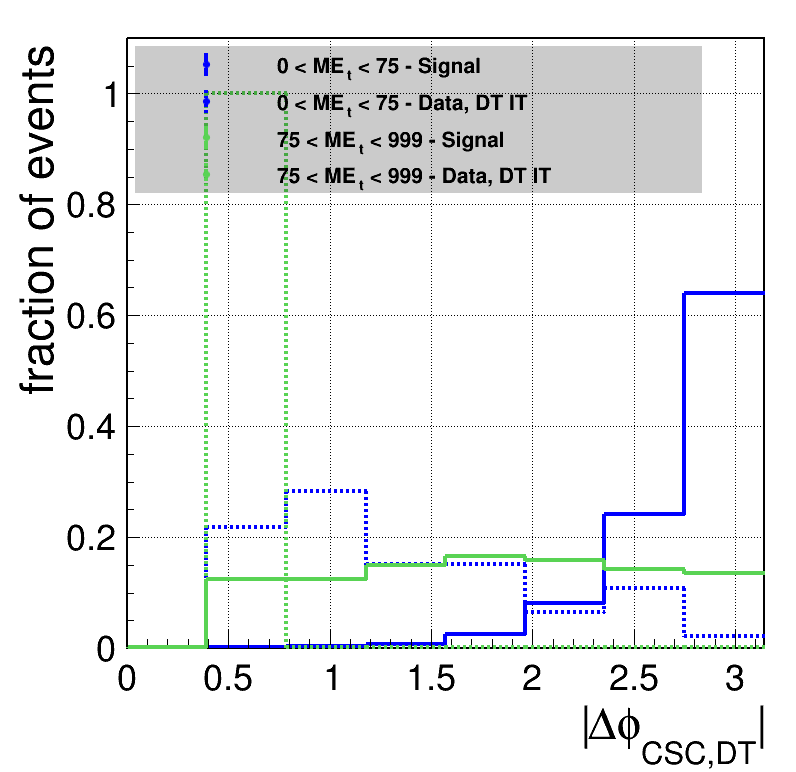

In [78]:
mets = [
    # (  0,  50),
    # ( 50,  999),
    # (  0,  100),
    # ( 100,  999),
    # (  0,  150),
    # ( 150,  999),
    # (  0,  200),
    # ( 200,  999),
    (  0,  75),
    ( 75,  999),
]

_v = [ms["tag_dPhi"][(met[0] < ms["met"])&(ms["met"]<met[1])] for met in mets for ms in mss]
_w = [ms["weight"][(met[0] < ms["met"])&(ms["met"]<met[1])] for met in mets for ms in mss]
_n = [f"{met[0]} < ME_{{t}} < {met[1]} - {ms.name}" for met in mets for ms in mss]
_c = [std_color_list[imet + 2] for imet, met in enumerate(mets) for ims, ms in enumerate(mss)]
_s = None#[rt.kDashed if ims else rt.kSolid for met in [(0,25),(25,50),(50,75)] for ims, ms in enumerate(mss)]

bins, log, norm = [8, 0, np.pi], False, True
axis_titles = ["|#Delta#phi_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, _s, log=log, norm=norm)
for ihist, hist in enumerate(hists):
    print(ihist, np.sum(_w[ihist]))
    hist.SetLineWidth(4)
    # hist.SetLineColor(std_color_list[ihist])
    if ihist % 2 == 1:
        hist.SetLineStyle(rt.kDashed)

canvas.Draw()

In [88]:
mids = np.arange(0, 200, 5)
mids = [25, 50, 75, 100, 150, 200, 250]
sl_yields = [np.sum(mss[0]["weight"][(0<mss[0]["met"])&(mss[0]["met"]<mid)]) for mid in mids]
su_yields = [np.sum(mss[0]["weight"][(mid<mss[0]["met"])&(mss[0]["met"]<9999)]) for mid in mids]

bl_yields = [np.sum(mss[1]["weight"][(0<mss[1]["met"])&(mss[1]["met"]<mid)]) for mid in mids]
bu_yields = [np.sum(mss[1]["weight"][(mid<mss[1]["met"])&(mss[1]["met"]<9999)]) for mid in mids]


print(f"| MET | Sig < MET | Sig > MET | Bkg < MET | Bkg > MET | ")
print(f"| --- | --------- | --------- | --------- | --------- |")
for mid, sl, su, bl, bu in zip(mids, sl_yields, su_yields, bl_yields, bu_yields):
    print(f"| {mid:>3} |    {sl:>6.2f} |    {su:>6.2f} |    {bl:>6.2f} |    {bu:>6.2f} | ")

| MET | Sig < MET | Sig > MET | Bkg < MET | Bkg > MET | 
| --- | --------- | --------- | --------- | --------- |
|  25 |    245.87 |    708.59 |     17.00 |     30.00 | 
|  50 |    578.72 |    375.75 |     37.00 |     10.00 | 
|  75 |    779.87 |    174.58 |     46.00 |      1.00 | 
| 100 |    865.05 |     89.41 |     47.00 |      0.00 | 
| 150 |    928.47 |     25.98 |     47.00 |      0.00 | 
| 200 |    944.78 |      9.67 |     47.00 |      0.00 | 
| 250 |    951.43 |      3.02 |     47.00 |      0.00 | 


NEV_SMEAR=100,000
0 39 0.6040899157524109 0.6040899157524109
1 39 0.40224552154541016 3.141534749661581
2 36 50.0 200
0 6 1.0 1.0
1 6 0.4168292284011841 3.0339582006083887
1 0.7871658289704646
2 6 51.0 200
2 0.031085172555103076
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =     0.697643
Chi2                      =      1.39529
NDf                       =            4
Edm                       =  2.63558e-06
NCalls                    =           37
Constant                  =      3.22893   +/-   0.324628    
Slope                     =    -0.787166   +/-   0.219501    
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      3.10094
Chi2                      =      6.20188
NDf                       =            4
Edm                       =  2.23651e-06
NCalls                    =           45
Constant                  =      5.16796   +/-   0.473918    
Slope                     =   -0.

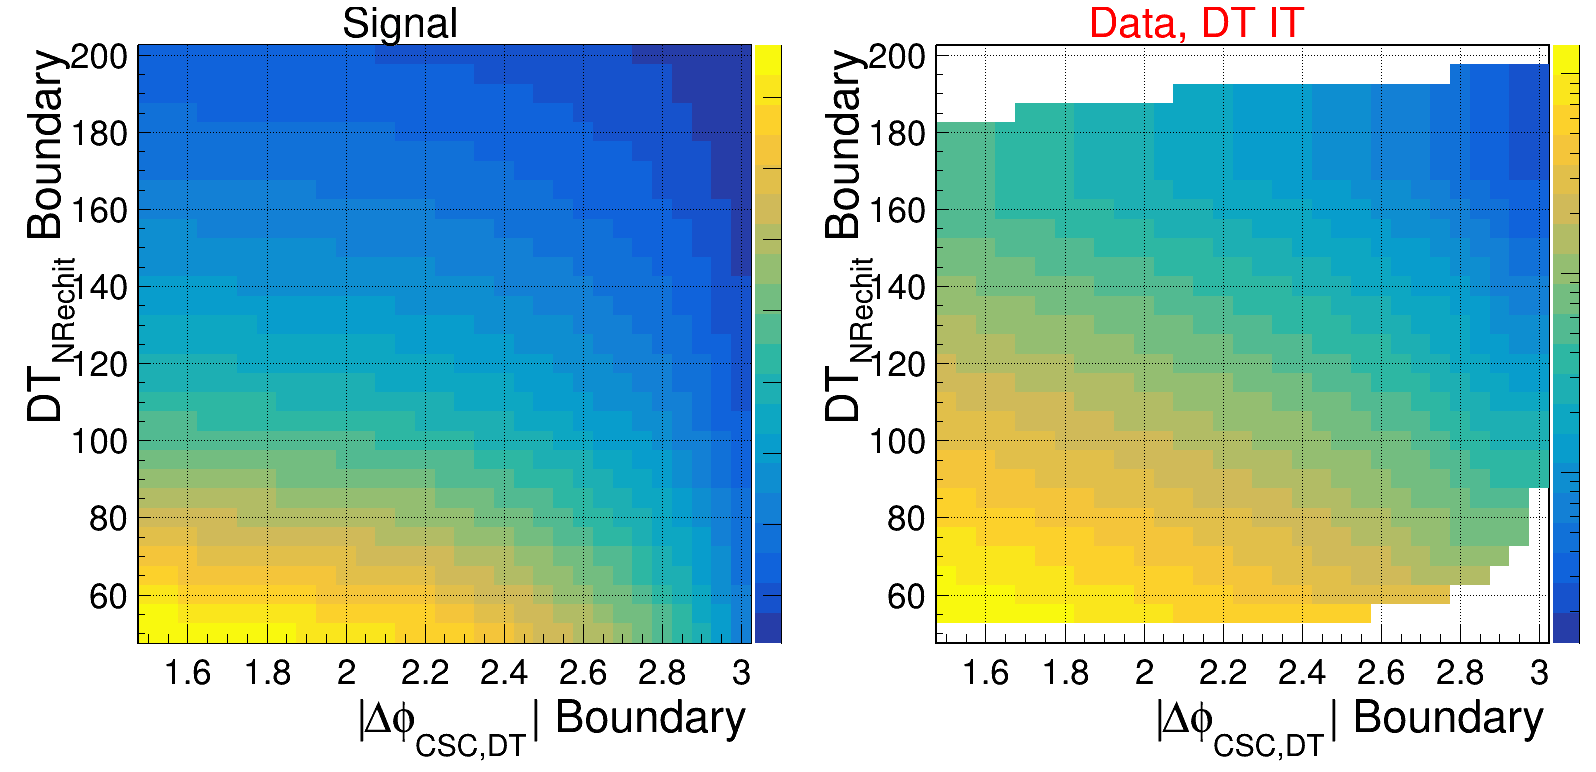

In [43]:
nth_sz, nth_df = (200-50)//5 + 1, (300-150)//5 + 1 # 31, 19
size_ths, dphi_ths = np.linspace(50, 200, nth_sz), np.linspace(1.5, 3.0, nth_df)
dth_sz, dth_df = size_ths[1]-size_ths[0], dphi_ths[1]-dphi_ths[0]
thresh_info = {}#{ms.name : [] for ms in mss}

print(f"{NEV_SMEAR=:,.0f}")

sz_conds, df_conds = [], []
for ims, ms in enumerate(mss):
    wt, df, sz = np.asarray(ms["weight"]), np.asarray(ms["tag_dPhi"]), np.asarray(ms["dtSize"][:,0])
    # if not ms.is_mc:
    #     blind_idx =  (sz < np.max(size_ths)) | (df < np.max(dphi_ths))
    #     wt, df, sz = wt[blind_idx], df[blind_idx], sz[blind_idx] 
    # wt = wt[np.random.randint(0, sz.shape[0], NEV_SMEAR)] * sz.shape[0] / NEV_SMEAR
    # df = df[np.random.randint(0, sz.shape[0], NEV_SMEAR)]
    # sz = sz[np.random.randint(0, sz.shape[0], NEV_SMEAR)]
    # sz = np.random.normal(sz, np.sqrt(sz))
    df_cond, sz_cond = df[None,:]>dphi_ths[:,None], sz[None,:]>size_ths[:,None]
    _has_data = np.array([
        (np.sum(wt[(df_cond[idf])&(~sz_cond[isz])])>0)*
        (np.sum(wt[(~df_cond[idf])&(~sz_cond[isz])])>0)*
        (np.sum(wt[(~df_cond[idf])&(sz_cond[isz])])>0) for idf in range(nth_df) for isz in range(nth_sz)])

    if NEV_SMEAR>0:
        wt, df, sz = smear(wt, df, sz, fit=ims>0, bootstrap=True, size=NEV_SMEAR)
    
    df_cond, sz_cond = df[None,:]>dphi_ths[:,None], sz[None,:]>size_ths[:,None]
    _abcd = np.array([
        [np.sum(wt[(df_cond[idf])&(sz_cond[isz])]),
         np.sum(wt[(df_cond[idf])&(~sz_cond[isz])]),
         np.sum(wt[(~df_cond[idf])&(~sz_cond[isz])]),
         np.sum(wt[(~df_cond[idf])&(sz_cond[isz])])] for idf in range(nth_df) for isz in range(nth_sz)]).T
    _err = np.sqrt(_abcd[0])
    
    sz_conds.append(np.sum(sz_cond,1).astype(float))
    df_conds.append(np.sum(df_cond,1).astype(float))

    # _abcd[_abcd<0.5] = 0
    # _abcd[_abcd<1] = 0
    # _abcd[_abcd<2] = 0
    # _abcd = np.round(_abcd) 
    _abcd[_abcd<1] = np.round(_abcd[_abcd<1]) 
    # _abcd[_abcd<2] = np.ceil(_abcd[_abcd<2]) 
    # _abcd[_abcd<1] = np.sqrt(_abcd[_abcd<1]) 
    # _abcd[_abcd<1] = np.round(np.sqrt(_abcd[_abcd<1])) 

    if not ms.is_mc:
        _abcd[0] = np.divide(_abcd[1]*_abcd[3], _abcd[2], out=np.zeros_like(_abcd[0]), where=_abcd[2]!=0)

        _idxs = (_abcd[1] * _abcd[2] * _abcd[3]) > 0
        _err[_idxs] = _abcd[0, _idxs] * np.sqrt(np.sum(1/_abcd[1:, _idxs]))
        _err[~_idxs] = 1
    
    thresh_info[ms.name] = np.array([
        [dphi_ths[idf], 
         size_ths[isz], 
         *_abcd[:,isz + idf*nth_sz], 
        _err[isz + idf*nth_sz], _has_data[isz + idf*nth_sz]] for idf in range(nth_df) for isz in range(nth_sz) ])


# *** #
# Event Counts
bins, log, norm = [nth_df, dphi_ths[0]-dth_df/2, dphi_ths[-1]+dth_df/2, nth_sz, size_ths[0]-dth_sz/2, size_ths[-1]+dth_sz/2], False, False
axis_titles = ["|#Delta#phi_{CSC,DT}| Boundary", "DT_{NRechit} Boundary", f"{'fraction of ' if norm else ''}SR events"]

_values = [np.asarray(thresh_info[ms.name][:,:2]) for ms in mss]
# _values += _values[1:]
_evts = [np.asarray(thresh_info[ms.name][:,2]) for ms in mss]
# _evts += _evts[1:]
_errs = [np.asarray(thresh_info[ms.name][:,6]) for ms in mss]
_hds = [np.asarray(thresh_info[ms.name][:,7]) for ms in mss]

_names = names + [f"{names[0]} / #sqrt{{names[i]}}" for i in range(1, len(names)-1)]
_v, _n, _w, _c = _values, _names, _evts, colors

# ims = 1
# _v, _n, _w, _c = _values[ims:ims+1], names[ims:ims+1], _evts[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm, share_scale=False)
for i in range(len(hists)):
    canvas.cd(ic + 1).SetLogz()
canvas.Draw()


In [44]:
sz_s2b = np.divide(sz_conds[0], np.sqrt(sz_conds[1]), out=np.zeros_like(sz_conds[0]), where=sz_conds[1]>0)
sz_idx = np.argmax(sz_s2b)
print(size_ths[sz_idx], sz_conds[0][sz_idx], sz_conds[1][sz_idx], sz_s2b[sz_idx])

df_s2b = np.divide(df_conds[0], np.sqrt(df_conds[1]), out=np.zeros_like(df_conds[0]), where=df_conds[1]>0)
df_idx = np.argmax(df_s2b)
print(dphi_ths[df_idx], df_conds[0][df_idx], df_conds[1][df_idx], df_s2b[df_idx])

180.0 19891.0 1702.0 482.1440809613973
2.8 50494.0 4025.0 795.8969370527429


X | dPhi = 2.70, dtSize =  80.0 -- Limit = 0.295%, S/Sqrt[B] = 405.12, S = 406.74, B =  1.01
O | dPhi = 2.40, dtSize = 100.0 -- Limit = 0.225%, S/Sqrt[B] = 394.56, S = 399.79, B =  1.03


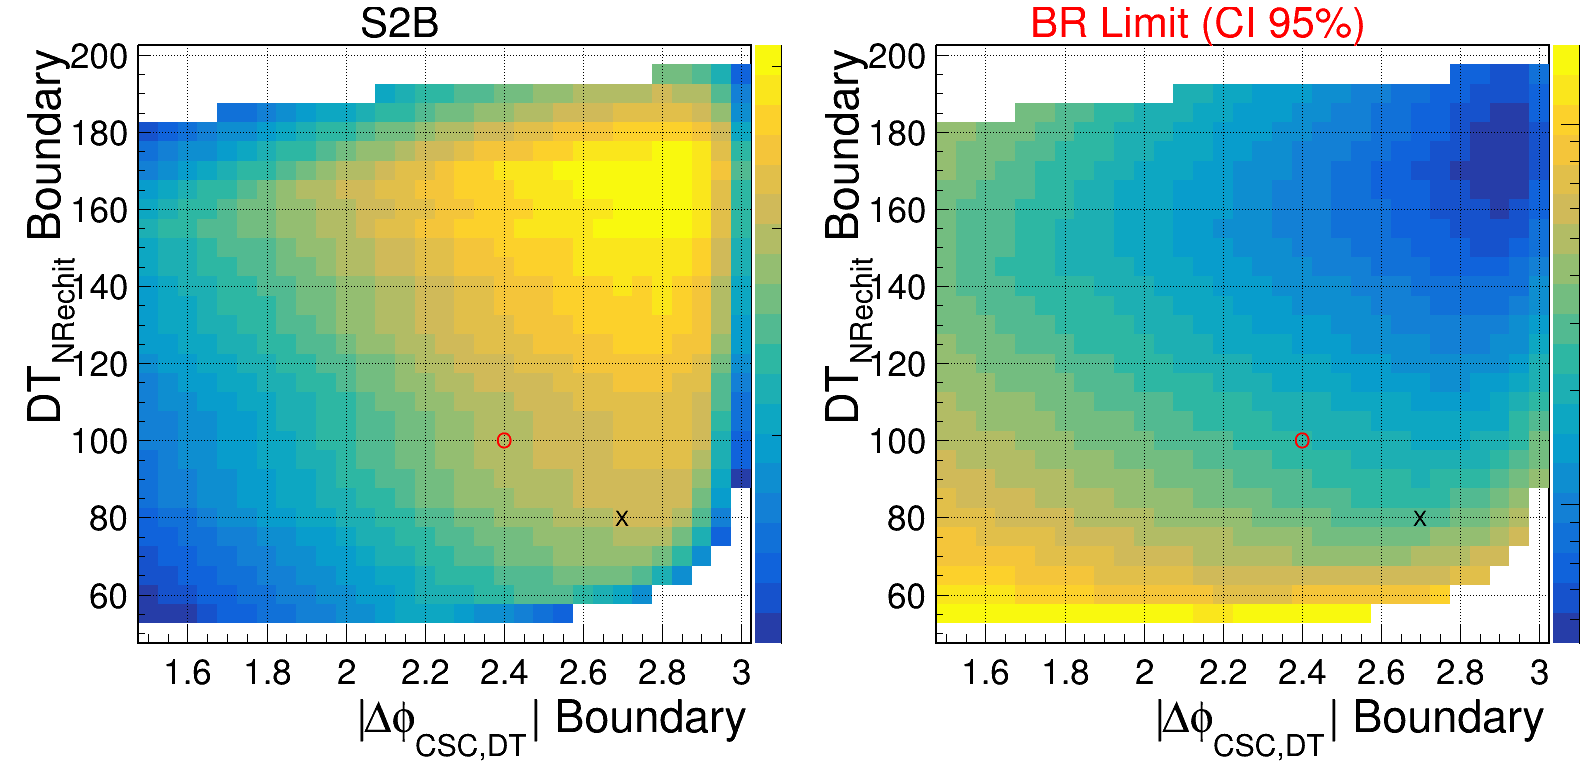

In [45]:
# S / Sqrt[ B ]
bins, log, norm = [nth_df, dphi_ths[0]-dth_df/2, dphi_ths[-1]+dth_df/2, nth_sz, size_ths[0]-dth_sz/2, size_ths[-1]+dth_sz/2], False, False
axis_titles = ["|#Delta#phi_{CSC,DT}| Boundary", "DT_{NRechit} Boundary", f"{'fraction of ' if norm else ''}"+"S / #sqrt{B}"]

# *** #
_evts = [thresh_info[ms.name][:,2] for ms in mss]
_hds = [thresh_info[ms.name][:,7] for ms in mss]
# *** #
# idxs = _evts[1] > 0
idxs = (_evts[1] > 0) & (_hds[1] > 0)
_evts = [evts[idxs] for evts in _evts]
_values = [thresh_info[ms.name][idxs,:2] for ms in mss]
_abcd = [thresh_info[ms.name][idxs,2:6] for ms in mss]
_errs = [thresh_info[ms.name][idxs,-1] for ms in mss]
# *** #
_s2b = _evts[0] / np.sqrt(_evts[1])
_lim = [find_CI_limit(sig, obs, do_verbose=False) for sig, obs in zip(_abcd[0], _abcd[1])]
_lim, _lime = np.asarray([l[0] for l in _lim]), np.asarray([l[2] for l in _lim])
# *** #
# idxs = _lim > 1e-4
# _evts = [x[idxs] for x in _evts]
# _values = [x[idxs] for x in _values]
# _abcd = [x[idxs] for x in _abcd]
# _errs = [x[idxs] for x in _errs]
# _s2b = _s2b[idxs]
# _lim = _lim[idxs]
# *** #

_v, _n, _c, _w = [_values[0], _values[0]], ["S2B", "BR Limit (CI 95%)"], [std_color_list[0], std_color_list[1]], [_s2b, _lim]
canvas, legend, hhs = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=False, norm=False)

lat, lls = rt.TLatex(), []
lat.SetTextAlign(22)
lat.SetTextSize(0.03)

for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetLogz()

    v, sig, bkg = _v[0], _evts[0], _evts[1]
    n, c, w = _n[ih], _c[ih], _w[ih]

    hh.SetMinimum(np.min(w))
    hh.SetMaximum(np.max(w))
    
    if ih == 0:
        # idx_s2b = np.argmax((w < np.quantile(w, 0.95)) * sig)
        idx_s2b = np.argmax(w * ((sig>1)&(bkg > 1)))
        # idx_s2b = np.argmax(w)
        idx = idx_s2b
        m = "X"
    elif ih == 1:
        idx_lim = np.argmin(w + np.max(w)*((sig<1)|(bkg<1)))
        # idx_lim = np.argmin(w)
        idx = idx_lim
        m = "O"

    df, sz, s, b = v[idx][0], v[idx][1], sig[idx], bkg[idx]
    s2b, lim = _s2b[idx], _lim[idx]
    lls.append((c, df, sz, f"{m} | dPhi = {df:4.2f}, dtSize = {sz:5.1f} -- Limit = {100*lim:5.3f}%, S/Sqrt[B] = {s2b:6.2f}, S = {s:6.2f}, B = {b:5.2f}"))

for ih, (n, c) in enumerate(zip(_n, _c)):
    canvas.cd(ih + 1)
    for cl, df, sz, ll in lls:
        lat.SetTextColor(cl)
        lat.DrawLatex(df, sz, ll[0])
        if ih == 0:
            print(ll)

canvas.Draw()

In [46]:
np.min(_lim)

0.00043215844594009917

In [47]:
# SIGNAL IN ABCD REGION A USING BEST S2B RATIO
# ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = 2.67, 121.0

for idx in [idx_s2b, idx_lim]:

    ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx]
    # ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx_s2b]
    # ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx_eff]
    # ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx_eff10]

    print(f"{ABCD_DPHI_S2B=:.3f}, {ABCD_DTSIZE_S2B=:3.0f}")
    print("SR Background Predictions from ABCD")

    abcd_sig, abcd_obs = [], []
    for ims, ms in enumerate(mss):
        dtsize, dphi = ms["dtSize"][:,0], ms["tag_dPhi"]
        a_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        b_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        c_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)
        d_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)
        vals, errs = calc_abcd(ms["weight"], a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())

        if ims == 0:
            abcd_sig = list(vals[1:5])
            asig = vals[1]
            ct = np.asarray(ms["gLLP_ctau"][:,ms["dt_match_gLLP_index"][:,0]])
        elif ims == 1:
            abcd_obs = list(vals[1:5])
            abcd_obs[0] = vals[0]

        print(f"{ms.name}: S/Sqrt[B] = {asig/np.sqrt(vals[0]):7.3f}")#:>{max([len(n) for n in names])}} :")
        print(f"\ta = " +(f"{vals[1]:7.3f} ± {errs[1]:7.3f}" if ms.is_mc else f"{vals[0]:7.3f} ± {errs[0]:7.3f} (b*d/c)"))
        print(f"\tb = {vals[2]:7.3f} ± {errs[2]:7.3f}")
        print(f"\tc = {vals[3]:7.3f} ± {errs[3]:7.3f}")
        print(f"\td = {vals[4]:7.3f} ± {errs[4]:7.3f}")


    lim, pp, le, pe = find_CI_limit(abcd_sig, abcd_obs, do_verbose=True)
    print(lim, pp, le, pe)


ABCD_DPHI_S2B=2.700, ABCD_DTSIZE_S2B= 80
SR Background Predictions from ABCD


Signal: S/Sqrt[B] =  17.034
	a = 392.661 ±  19.816
	b = 164.917 ±  12.842
	c =  92.426 ±   9.614
	d = 297.818 ±  17.257
Data, DT IT: S/Sqrt[B] = 528.636
	a =   0.552 ±   0.578 (b*d/c)
	b =   1.000 ±   1.000
	c =  29.000 ±   5.385
	d =  16.000 ±   4.000
|   |    Obs | FitBkg |    Sig |
|---+--------+--------+--------+
| A |   0.55 |   0.01 |   0.94 |
| B |   1.00 |   0.03 |   0.39 |
| C |  29.00 |  29.46 |   0.22 |
| D |  16.00 |  14.58 |   0.71 |
Limit = 0.239%
0.0023865012042863032 [1.35030388e-02 2.72872440e-02 2.94626460e+01 1.45795322e+01] 2.75711805883595e-08 [1.08198357e-05 2.18553528e-05 1.83324035e-04 3.34312846e-04]
ABCD_DPHI_S2B=2.400, ABCD_DTSIZE_S2B=100
SR Background Predictions from ABCD
Signal: S/Sqrt[B] =  17.620
	a = 389.640 ±  19.739
	b = 323.190 ±  17.977
	c =  93.030 ±   9.645
	d = 140.753 ±  11.864
Data, DT IT: S/Sqrt[B] = 270.886
	a =   2.069 ±   1.166 (b*d/c)
	b =   5.000 ±   2.236
	c =  29.000 ±   5.385
	d =  12.000 ±   3.464
|   |    Obs | FitBkg |    Sig |
|---

In [48]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    if llp_ct.ndim > 1:
        llp_ct = np.array(np.sum(llp_ct, axis=1))
    source = np.exp(-1.0 * llp_ct / old_ctau) / old_ctau**2
    weight = 1.0 / new_ctau**2 * np.exp(-1.0 * llp_ct / new_ctau) / source
    return weight

_limits, _elimits = [], []
_s2bs = []
min_mets = np.arange(0, 50.0, 1).astype(float)
ct = 1000
for min_met in min_mets:
    _abcd_sig, _abcd_obs = [], []
    do_break = False
    for ims, ms in enumerate(mss):
        idx_met = ms["met"] >= min_met

        dtsize, dphi = np.asarray(ms["dtSize"][idx_met,0]), np.asarray(ms["tag_dPhi"][idx_met])
        wt = np.asarray(ms["weight"][idx_met])
        a_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        b_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        c_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)
        d_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)

        if np.sum(b_cond)*np.sum(c_cond)*np.sum(d_cond) == 0:
            do_break = True
            break

        if ims == 0 and ct != 1000: #ms["dt_match_gLLP_index"][:,0]
            gllp_ctau = np.asarray(ms["gLLP_ctau"][idx_met,0])
            wt *= weight_calc(gllp_ctau, ct/10, 1000/10)

        vals, errs = calc_abcd(wt, a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())

        if ims == 0:
            _abcd_sig = list(vals[1:5])
            asig = vals[1]
        elif ims == 1:
            _abcd_obs = list(vals[1:5])
            _abcd_obs[0] = vals[0]
            _s2bs.append(asig/np.sqrt(vals[0]))

        # print(f"{ms.name}: S/Sqrt[B] = {asig/np.sqrt(vals[0]):7.3f}")#:>{max([len(n) for n in names])}} :")
        # print(f"\ta = " +(f"{vals[1]:7.3f} ± {errs[1]:7.3f}" if ms.is_mc else f"{vals[0]:7.3f} ± {errs[0]:7.3f} (b*d/c)"))
        # print(f"\tb = {vals[2]:7.3f} ± {errs[2]:7.3f}")
        # print(f"\tc = {vals[3]:7.3f} ± {errs[3]:7.3f}")
        # print(f"\td = {vals[4]:7.3f} ± {errs[4]:7.3f}")
    if do_break:
        break
    lv, pv, le, pe = find_CI_limit(_abcd_sig, _abcd_obs, do_verbose=False)
    _limits.append(lv)
    _elimits.append(le)
    # print(f"{ct:0>7.0f} - {asig:7.2f}, {vals[0]:5.2f}, {asig/np.sqrt(vals[0]):7.2f}")
    
    norm = 10**int(np.log10(5/sum(_abcd_sig)))
    fdc = f"datacard_ct{ct:0>8.0f}.txt"

#     print(f"combine -M AsymptoticLimits --freezeParam norm --setParameters norm={norm} {fdc}")
#     str_dc = f"""# norm {norm}
# # CTAU {ct}
# # ABCD_DPHI {ABCD_DPHI_S2B}
# # ABCD_SIZE {ABCD_DTSIZE_S2B}
# # LIMIT {lv} {le}
# imax 4
# jmax 1
# kmax *
# shapes * * FAKE
# ---------------
# ---------------
# bin \t chA \t chB \t chC \t chD
# observation \t {abcd_obs[0]:.3f} \t {abcd_obs[1]:.3f} \t {abcd_obs[2]:.3f} \t {abcd_obs[3]:.3f}
# ------------------------------
# bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
# process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
# process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
# rate \t {abcd_sig[0]:.6e} \t 1 \t {abcd_sig[1]:.6e} \t 1 \t {abcd_sig[2]:.6e} \t 1 \t {abcd_sig[3]:.6e} \t 1
# ------------------------------
# single_A \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B,single_C,single_D
# single_B \t rateParam \t chB \t bkg \t {abcd_obs[1]:.3f} \t [0,{7*abcd_obs[1]:.3f}]
# single_C \t rateParam \t chC \t bkg \t {abcd_obs[2]:.3f} \t [0,{7*abcd_obs[2]:.3f}]
# single_D \t rateParam \t chD \t bkg \t {abcd_obs[3]:.3f} \t [0,{7*abcd_obs[3]:.3f}]
# norm rateParam * sig 1
# single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
# """
#     if WRITE_DATACARDS:
#         with open(f"data/datacard_scan/{fdc}", "w") as fdc:
#             fdc.write(str_dc)

_s2bs, _limits, _elimits = np.asarray(_s2bs).astype(float), np.asarray(_limits).astype(float), np.asarray(_elimits).astype(float)

0 50 50 50
	 <class 'int'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
1 50 50 50
	 <class 'int'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


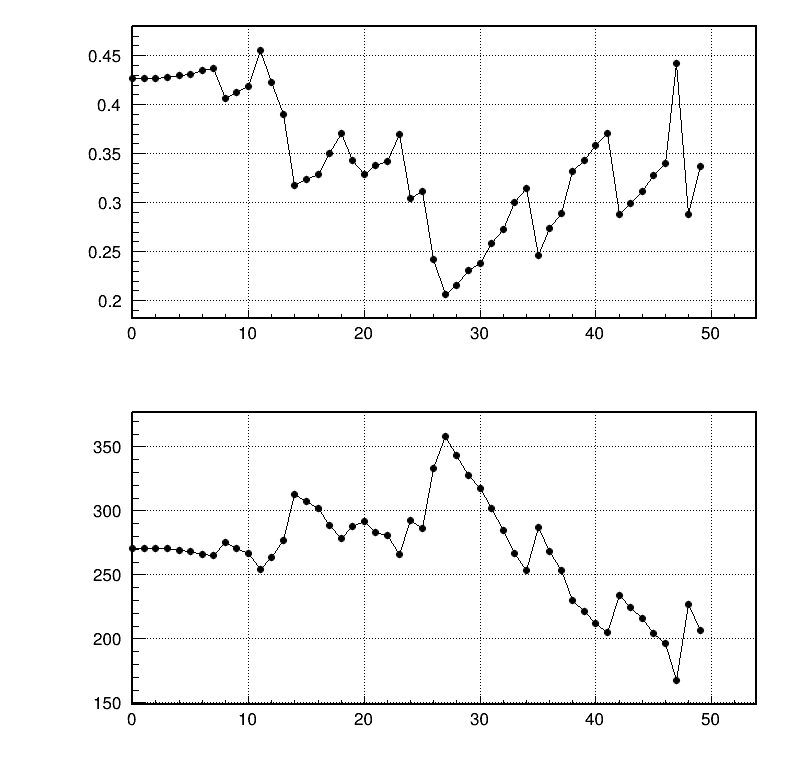

In [49]:
canvas = rt.TCanvas("","",800,800)
canvas.Divide(1,2)

for iyy, yy in enumerate([_limits*100, _s2bs]):
    canvas.cd(iyy + 1).SetRightMargin(0.04)
    # canvas.cd(iyy + 1).SetLogx()
    # canvas.cd(iyy + 1).SetLogy()
    canvas.cd(iyy + 1).SetGrid()
    # gr = rt.TGraphErrors(len(limits), ct*1.0, limits*1.0, ct*0.0, limits*0.0)
    print(iyy, len(yy), len(min_mets[:len(yy)]), len(yy))#, min_mets[:len(yy)]*1.0, yy*1.0, 
    print("\t", type(len(yy)), type(min_mets[:len(yy)]), type(yy))#, min_mets[:len(yy)]*1.0, yy*1.0, 
    # assert len(min_mets[:len(yy)]*1.0) == len(yy*1.0)
    gr = rt.TGraph(len(yy), min_mets[:len(yy)], yy)
    gr.Draw("ALP")
    gc.append(gr)

canvas.Draw()

# Write Datacards

`combine -M AsymptoticLimits --freezeParam norm --setParameters norm=0.01 datacard_test.txt`

In [50]:
print(f"""# norm {10**int(np.log10(5/sum(abcd_sig)))}
# ABCD_DPHI {ABCD_DPHI_S2B}
# ABCD_SIZE {ABCD_DTSIZE_S2B}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {abcd_obs[0]:.3f} \t {abcd_obs[1]:.3f} \t {abcd_obs[2]:.3f} \t {abcd_obs[3]:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {abcd_sig[0]:.3f} \t 1 \t {abcd_sig[1]:.3f} \t 1 \t {abcd_sig[2]:.3f} \t 1 \t {abcd_sig[3]:.3f} \t 1
------------------------------
single_A \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B,single_C,single_D
single_B \t rateParam \t chB \t bkg \t {abcd_obs[1]:.3f} \t [0,{7*abcd_obs[1]:.3f}]
single_C \t rateParam \t chC \t bkg \t {abcd_obs[2]:.3f} \t [0,{7*abcd_obs[2]:.3f}]
single_D \t rateParam \t chD \t bkg \t {abcd_obs[3]:.3f} \t [0,{7*abcd_obs[3]:.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
""")

# norm 0.01
# ABCD_DPHI 2.4
# ABCD_SIZE 100.0
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	 2.069 	 5.000 	 29.000 	 12.000
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 sig 	 bkg 	 sig 	 bkg 	 sig 	 bkg 	 sig 	 bkg
process 	 0 	 1 	 0 	 1 	 0 	 1 	 0 	 1
rate 	 389.640 	 1 	 323.190 	 1 	 93.030 	 1 	 140.753 	 1
------------------------------
single_A 	 rateParam 	 chA 	 bkg 	 (@0*@2/@1) 	 single_B,single_C,single_D
single_B 	 rateParam 	 chB 	 bkg 	 5.000 	 [0,35.000]
single_C 	 rateParam 	 chC 	 bkg 	 29.000 	 [0,203.000]
single_D 	 rateParam 	 chD 	 bkg 	 12.000 	 [0,84.000]
norm rateParam * sig 1
single_lumi 	 lnN 	 1.2 	 - 	 1.2 	 - 	 1.2 	 - 	 1.2 	 -



In [51]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    if llp_ct.ndim > 1:
        llp_ct = np.array(np.sum(llp_ct, axis=1))
    source = np.exp(-1.0 * llp_ct / old_ctau) / old_ctau**2
    weight = 1.0 / new_ctau**2 * np.exp(-1.0 * llp_ct / new_ctau) / source
    return weight

ctaus = np.logspace(1, 7, 55)
limits, elimits = [], []
s2bs = []
for ct in ctaus:
    abcd_sig, abcd_obs = [], []
    for ims, ms in enumerate(mss):
        dtsize, dphi = ms["dtSize"][:,0], ms["tag_dPhi"]
        a_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        b_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        c_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)
        d_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)

        wt = np.asarray(ms["weight"])
        if ims == 0: #ms["dt_match_gLLP_index"][:,0]
            wt *= weight_calc(np.asarray(ms["gLLP_ctau"][:,0]), ct/10, 1000/10)

        vals, errs = calc_abcd(wt, a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())

        if ims == 0:
            abcd_sig = list(vals[1:5])
            asig = vals[1]
        elif ims == 1:
            abcd_obs = list(vals[1:5])
            abcd_obs[0] = vals[0]
            s2bs.append(asig/np.sqrt(vals[0]))

        # print(f"{ms.name}: S/Sqrt[B] = {asig/np.sqrt(vals[0]):7.3f}")#:>{max([len(n) for n in names])}} :")
        # print(f"\ta = " +(f"{vals[1]:7.3f} ± {errs[1]:7.3f}" if ms.is_mc else f"{vals[0]:7.3f} ± {errs[0]:7.3f} (b*d/c)"))
        # print(f"\tb = {vals[2]:7.3f} ± {errs[2]:7.3f}")
        # print(f"\tc = {vals[3]:7.3f} ± {errs[3]:7.3f}")
        # print(f"\td = {vals[4]:7.3f} ± {errs[4]:7.3f}")
    lv, pv, le, pe = find_CI_limit(abcd_sig, abcd_obs, do_verbose=False)
    limits.append(lv)
    elimits.append(le)
    # print(f"{ct:0>7.0f} - {asig:7.2f}, {vals[0]:5.2f}, {asig/np.sqrt(vals[0]):7.2f}")
    
    norm = 10**int(np.log10(5/sum(abcd_sig)))
    fdc = f"datacard_ct{ct:0>8.0f}.txt"

    print(f"combine -M AsymptoticLimits --freezeParam norm --setParameters norm={norm} {fdc}")
    str_dc = f"""# norm {norm}
# CTAU {ct}
# ABCD_DPHI {ABCD_DPHI_S2B}
# ABCD_SIZE {ABCD_DTSIZE_S2B}
# LIMIT {lv} {le}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {abcd_obs[0]:.3f} \t {abcd_obs[1]:.3f} \t {abcd_obs[2]:.3f} \t {abcd_obs[3]:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {abcd_sig[0]:.6e} \t 1 \t {abcd_sig[1]:.6e} \t 1 \t {abcd_sig[2]:.6e} \t 1 \t {abcd_sig[3]:.6e} \t 1
------------------------------
single_A \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B,single_C,single_D
single_B \t rateParam \t chB \t bkg \t {abcd_obs[1]:.3f} \t [0,{7*abcd_obs[1]:.3f}]
single_C \t rateParam \t chC \t bkg \t {abcd_obs[2]:.3f} \t [0,{7*abcd_obs[2]:.3f}]
single_D \t rateParam \t chD \t bkg \t {abcd_obs[3]:.3f} \t [0,{7*abcd_obs[3]:.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
"""
    # if WRITE_DATACARDS:
    #     with open(f"data/datacard_scan/{fdc}", "w") as fdc:
    #         fdc.write(str_dc)

    

    
limits, elimits = np.asarray(limits), np.asarray(elimits)

combine -M AsymptoticLimits --freezeParam norm --setParameters norm=10000000000 datacard_ct00000010.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=10000000 datacard_ct00000013.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=100000 datacard_ct00000017.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1000 datacard_ct00000022.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=100 datacard_ct00000028.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=10 datacard_ct00000036.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1 datacard_ct00000046.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1 datacard_ct00000060.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1 datacard_ct00000077.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=0.1 datacard_ct00000100.txt
combine -M AsymptoticLimits --

In [52]:
ctau_limit_r2 = np.asarray([
[8.000000000000000167e-03,2.221748833003930122e+04,3.147477513422234551e+04,5.924663554677147476e+04,9.703217496594259865e+04,1.697693397603968915e+05,6.255472399155191670e+04],
[8.999999999999999320e-03,6.049437990083955810e+03,8.966131306731576842e+03,1.382728683447761432e+04,2.352772949924181376e+04,4.088932086035796965e+04,1.576130006253232932e+04],
[1.000000000000000021e-02,2.072974294036226183e+03,2.953988369001622232e+03,4.422345160610615494e+03,7.947876372428057948e+03,1.327583595050091935e+04,5.122443537665780241e+03],
[1.099999999999999936e-02,8.656290812423252419e+02,1.224753215162902052e+03,1.910353834465821137e+03,3.250550270950253434e+03,5.769129498712238274e+03,2.075579436065037498e+03],
[1.200000000000000025e-02,4.148971050815575268e+02,5.792017237426268821e+02,9.156349905248166579e+02,1.572591887993693717e+03,2.774845716236349290e+03,9.892961040124017700e+02],
[1.299999999999999940e-02,2.297476800148233451e+02,3.179109184527150660e+02,4.984356447779218229e+02,8.520834961854717449e+02,1.500117111597714711e+03,5.311652397007906075e+02],
[1.400000000000000029e-02,1.395479423499639893e+02,1.935183289297721387e+02,3.002039768200905883e+02,5.084168909738795605e+02,8.844378941367614289e+02,3.140915089186253226e+02],
[1.499999999999999944e-02,9.192508024601301031e+01,1.266324491708652573e+02,1.928919716637650197e+02,3.236008277499174142e+02,5.557411915173181569e+02,1.993048115445596693e+02],
[1.600000000000000033e-02,6.432073791253597506e+01,8.661444605558384069e+01,1.306834040127714900e+02,2.171544006559442721e+02,3.692274723553575200e+02,1.338063021712043792e+02],
[1.700000000000000122e-02,4.651668368269754694e+01,6.190110771317304028e+01,9.231217847108970886e+01,1.519217394526816634e+02,2.565604469123721287e+02,9.372559115055844359e+01],
[1.799999999999999864e-02,3.454845067187463314e+01,4.562299279743081826e+01,6.751452955725117988e+01,1.100348302238596574e+02,1.844621744916519788e+02,6.798967779953972013e+01],
[1.899999999999999953e-02,2.612383728459190735e+01,3.446379812225104189e+01,5.066441170345097333e+01,8.176478837773939290e+01,1.365533298591730613e+02,5.084707848328622504e+01],
[2.000000000000000042e-02,2.037626023496367011e+01,2.660841165710798961e+01,3.892778074739327820e+01,6.282362231796967933e+01,1.040521880230060106e+02,3.893378578655236311e+01],
[2.999999999999999889e-02,3.209323632861958320e+00,4.213734154154110456e+00,6.131245149348218959e+00,9.699398162899850462e+00,1.522003109234466045e+01,6.004689117657667552e+00],
[4.000000000000000083e-02,1.036926554973880199e+00,1.393370058246151455e+00,2.073853109947760398e+00,3.280757400341239638e+00,5.100800812881489676e+00,1.997857798224575099e+00],
[5.000000000000000278e-02,4.740395834859888469e-01,6.542432742357121578e-01,9.866189705074238647e-01,1.576524810448842073e+00,2.466299336236762230e+00,9.420990940863247509e-01],
[5.999999999999999778e-02,2.501808458537865820e-01,3.553283570746444409e-01,5.427652249031301723e-01,8.845959227359482258e-01,1.393184012658813753e+00,5.158141893045967707e-01],
[7.000000000000000666e-02,1.338016311097519062e-01,2.011283199117943066e-01,3.171594218897823003e-01,5.219616089391164726e-01,8.434464946903142968e-01,2.978785972380944558e-01],
[8.000000000000000167e-02,7.193872483291666176e-02,1.136200587045396032e-01,1.879215669104761788e-01,3.152623567538841431e-01,5.174041451821439486e-01,1.734827702187018428e-01],
[8.999999999999999667e-02,3.952216926828173993e-02,6.359581203600657429e-02,1.111832454140673082e-01,1.936149401253561830e-01,3.222898253986500317e-01,1.011587598667618298e-01],
[1.000000000000000056e-01,2.304558459642371687e-02,3.689680630742382672e-02,6.628842310881429001e-02,1.196625760622291729e-01,2.009334792306831929e-01,5.919325227539306428e-02],
[2.000000000000000111e-01,2.481675250726738443e-03,3.947845542084913589e-03,7.058987379844944635e-03,1.308039686837708833e-02,2.139984215943784018e-02,6.302232440735751340e-03],
[2.999999999999999889e-01,1.123262584549845466e-03,1.786884559414971029e-03,3.195058018275115982e-03,5.920484530698992727e-03,9.686054860762006308e-03,2.849149062118688704e-03],
[4.000000000000000222e-01,8.246642762074787815e-04,1.311874785223806966e-03,2.345711718990162002e-03,4.346634646699776457e-03,7.111198330416160576e-03,2.092731573156944667e-03],
[5.000000000000000000e-01,7.322614108560061190e-04,1.164880435359997267e-03,2.082876901990417685e-03,3.859598258311682916e-03,6.314395369272623321e-03,1.859740057737747010e-03],
[5.999999999999999778e-01,7.113840535530352883e-04,1.131668764358760701e-03,2.023492418995300260e-03,3.749558014228135654e-03,6.134367108013739391e-03,1.806490751768457387e-03],
[6.999999999999999556e-01,7.242567680707805329e-04,1.152146660734819882e-03,2.060108140290220144e-03,3.817407409331369673e-03,6.245370068691448451e-03,1.837256020785586362e-03],
[8.000000000000000444e-01,7.537002397091977467e-04,1.209845905616535079e-03,2.143858459617273282e-03,3.972597970736834253e-03,6.499265191564514849e-03,1.916111363400223614e-03],
[9.000000000000000222e-01,7.991478058536758333e-04,1.271283219624519314e-03,2.273131536650455694e-03,4.212142666127873664e-03,6.891166280649330816e-03,2.026833465862559486e-03],
[1.000000000000000000e+00,8.506600728352425476e-04,1.365486637749071608e-03,2.419655318286912174e-03,4.483653297202875795e-03,7.335363777701092887e-03,2.162840445525795584e-03],
[2.000000000000000000e+00,1.677490758000426329e-03,2.692722143831934468e-03,4.771529267201212593e-03,8.841706436405786032e-03,1.446524385592458904e-02,4.266324952209582175e-03],
[3.000000000000000000e+00,2.914203546836488176e-03,4.677903818411487634e-03,8.289290088779344493e-03,1.536016384792063608e-02,2.512959609343601991e-02,7.410683967974283567e-03],
[4.000000000000000000e+00,4.524779533574148013e-03,7.263213813789335532e-03,1.287048400661090948e-02,2.374657108396051666e-02,3.901702129647799389e-02,1.149474070031710794e-02],
[5.000000000000000000e+00,6.501017183986123639e-03,1.043548695887772625e-02,1.849178221222719590e-02,3.397068046343449527e-02,5.605690286914026543e-02,1.652459114318254388e-02],
[6.000000000000000000e+00,8.843954523961895797e-03,1.419638950148466652e-02,2.515613731260272351e-02,4.621356018092419304e-02,7.625955388687520597e-02,2.249151139272922637e-02],
[7.000000000000000000e+00,1.155891379783626285e-02,1.855446475256841699e-02,3.287868813606759089e-02,5.987619509396084616e-02,9.966598260055456460e-02,2.939572611061764748e-02],
[8.000000000000000000e+00,1.465339525404455931e-02,2.352175217341944194e-02,4.168076872261563398e-02,7.590588320479971229e-02,1.263479506988853807e-01,3.723777476808861481e-02],
[9.000000000000000000e+00,1.807151536856825905e-02,2.900854706558717369e-02,5.140342149281638268e-02,9.361204632975651807e-02,1.558204647345313443e-01,4.601892316250372206e-02],
[2.000000000000000000e+01,8.054576680776141806e-02,1.292927360945420323e-01,2.291079589198547206e-01,4.062753760955533644e-01,6.717268624843629743e-01,2.050242774315411132e-01],
[3.000000000000000000e+01,1.774611351447364094e-01,2.830419787705110712e-01,4.992313252423354331e-01,8.773232262674450777e-01,1.432987720911233609e+00,4.482510960947150291e-01],
[2.000000000000000000e+02,1.195104449014488246e+01,1.744543811057421223e+01,3.121905499466418021e+01,6.282693786806134284e+01,9.468175895133146014e+01,3.077200922355739721e+01],
[3.000000000000000000e+02,2.355644093664349370e+01,3.420907546848026470e+01,6.091362504829024260e+01,1.225859218933242687e+02,1.847400369677051231e+02,5.924333524335708034e+01],
[5.000000000000000000e+02,5.337256141727425529e+01,7.757402262115307678e+01,1.394222012532878523e+02,2.805808937225613136e+02,4.228423791888683354e+02,1.359611380262283831e+02],
[6.000000000000000000e+02,7.081028033364950147e+01,1.034550970725194787e+02,1.868807398496316523e+02,3.760890542922808777e+02,5.667755645541238891e+02,1.815595888649672531e+02],
[7.000000000000000000e+02,8.932537550519964498e+01,1.311966452732619643e+02,2.382010013471990533e+02,4.793687827579618670e+02,7.224206242883795994e+02,2.310570033176519189e+02],
[8.000000000000000000e+02,1.100809872030777683e+02,1.616814499545204740e+02,2.935492992082074011e+02,5.907546976724601109e+02,8.902820316423022859e+02,2.840507623710278153e+02],
[9.000000000000000000e+02,1.304523850552158422e+02,1.926318278002841851e+02,3.515348481487921504e+02,7.074479990732680790e+02,1.066141791596601706e+03,3.412077289106244393e+02],
[1.000000000000000000e+03,1.523117033102302003e+02,2.251129504625850757e+02,4.148063409299886075e+02,8.347790059842131996e+02,1.258032820695829741e+03,4.012740347579924673e+02],
[2.000000000000000000e+03,4.095654951912853790e+02,6.271103860009525306e+02,1.205158238723782233e+03,2.425326603116699516e+03,3.655027424944374616e+03,1.136488166871029989e+03],
[3.000000000000000000e+03,6.586338179269149578e+02,1.050609521673372228e+03,2.134307055560635945e+03,4.295196596089878767e+03,6.472968539447957482e+03,2.044114950277029948e+03],
[5.000000000000000000e+03,1.199847141806243144e+03,2.018074767394292394e+03,4.326209412709834396e+03,8.706301315724898814e+03,1.312061275576623848e+04,4.161159235849583638e+03],
[6.000000000000000000e+03,1.474093286293830943e+03,2.519661378683743351e+03,5.469099728858271192e+03,1.100631636651074041e+04,1.658679324005013041e+04,5.286957650854065832e+03],
[7.000000000000000000e+03,1.738498728306707108e+03,3.002843011008308622e+03,6.642622006664433684e+03,1.336797688988407572e+04,2.014587309879034001e+04,6.428266329881121237e+03],
[8.000000000000000000e+03,1.992519967761837052e+03,3.501997534685257506e+03,7.847463257646619240e+03,1.579266589955587369e+04,2.379994054104843235e+04,7.614789661960687226e+03],
[9.000000000000000000e+03,2.262221532335473057e+03,4.011908498751191019e+03,9.048886129341892229e+03,1.821047517199769572e+04,2.744363928690943430e+04,8.810298771652958749e+03],
])

# ct_cscdt_r2, limit_cscdt_r2, elimit_cscdt_r2 = ctau_limit_r2[:,0], ctau_limit_r2[:,-1], np.abs((ctau_limit_r2[:,3]- ctau_limit_r2[:,2])/2)
ct_cscdt_r2, limit_cscdt_r2, elimit_cscdt_r2 = ctau_limit_r2[:,0], ctau_limit_r2[:,-1], np.std(ctau_limit_r2[:,1:-1], axis=1)

In [53]:
ct_cscdt_r2.astype(float).dtype, limit_cscdt_r2.dtype, len(ct_cscdt_r2)

(dtype('float64'), dtype('float64'), 55)

In [54]:
# ctau_limit_r3 = np.array([[10.0, 2.85556640625e+11, 3.51575088501e+11, 4.5125e+11, 6.00542259216e+11, 8.0550994873e+11, 4.51629670996e+11],
# [13.0, 228764648.438, 282547874.451, 363750000.0, 486993446.35, 658701705.933, 363287465.787],
# [17.0, 1054077.14844, 1324100.49438, 1718750.0, 2218873.78693, 2888533.40149, 1713396.85044],
# [22.0, 20616.2109375, 23707.6034546, 28375.0, 35500.5493164, 45617.6109314, 28315.722186],
# [28.0, 935.461425781, 1040.52276611, 1215.625, 1501.51147842, 1921.65336609, 1215.23354784],
# [36.0, 84.2932128906, 92.9700660706, 108.4375, 133.93945694, 169.887695312, 108.615903964],
# [46.0, 12.3923339844, 13.9724769592, 16.4375, 20.4342556, 26.0902690887, 16.4361875585],
# [60.0, 2.11486816406, 2.76052951813, 3.515625, 4.52459192276, 5.89747047424, 3.5206144301],
# [77.0, 0.438385009766, 0.594401597977, 0.86328125, 1.25900495052, 1.7019225359, 0.863858102644],
# [100.0, 0.125634765625, 0.173697662354, 0.259375, 0.39688103199, 0.58820939064, 0.259102275764],
# [129.0, 0.0474502563477, 0.0664757013321, 0.100390625, 0.155212724209, 0.234346199036, 0.100324876106],
# [167.0, 0.0226135253906, 0.0316236019135, 0.0482421875, 0.0749712526798, 0.112515437603, 0.0482439735929],
# [215.0, 0.012801361084, 0.0179825842381, 0.0275390625, 0.0426875829697, 0.0641771435738, 0.0275688847392],
# [278.0, 0.00839050292969, 0.0119169139862, 0.018203125, 0.0279985141754, 0.0422100496292, 0.0181747112635],
# [359.0, 0.00628387451172, 0.00892489910126, 0.0136328125, 0.0208601617813, 0.0312382268906, 0.0136330453899],
# [464.0, 0.00532028198242, 0.00752146482468, 0.0114453125, 0.0174217295647, 0.026044728756, 0.011441848711],
# [599.0, 0.00495712280273, 0.00705263972282, 0.0106640625, 0.016147518158, 0.0240969014168, 0.0106549459495],
# [774.0, 0.005126953125, 0.00726051330566, 0.0109375, 0.0165179598331, 0.0245616698265, 0.0109550124472],
# [1000.0, 0.00573120117188, 0.00811621665955, 0.0122265625, 0.0183672487736, 0.0274057984352, 0.012225020504],
# [1292.0, 0.006884765625, 0.00981079101563, 0.0146875, 0.0220056247711, 0.0327145576477, 0.0146977916671],
# [1668.0, 0.0088623046875, 0.0125701904297, 0.01875, 0.0280922889709, 0.0417632675171, 0.0187939332973],
# [2154.0, 0.0120536804199, 0.0170184135437, 0.02529296875, 0.0378953248262, 0.0561844944954, 0.0253217573601],
# [2783.0, 0.0169403076172, 0.0239177703857, 0.035546875, 0.0532582938671, 0.0787477970123, 0.0356213976733],
# [3594.0, 0.0246658325195, 0.0350369811058, 0.0517578125, 0.0775464177132, 0.114660251141, 0.0519119954469],
# [4642.0, 0.0370452880859, 0.0526215791702, 0.077734375, 0.11584624052, 0.171875083447, 0.0778107377985],
# [5995.0, 0.0567779541016, 0.0806511640549, 0.119140625, 0.178028178215, 0.263680791855, 0.11938972821],
# [7743.0, 0.0889831542969, 0.126397562027, 0.18671875, 0.278263831139, 0.411714744568, 0.186615713378],
# [10000.0, 0.140548706055, 0.199644684792, 0.294921875, 0.439517140388, 0.652088880539, 0.295502684778],
# [12915.0, 0.227096557617, 0.321099877357, 0.47265625, 0.704391717911, 1.04506957531, 0.473461577945],
# [16681.0, 0.364868164062, 0.51828289032, 0.765625, 1.14099812508, 1.68820273876, 0.765554422708],
# [21544.0, 0.598709106445, 0.846536040306, 1.24609375, 1.85703265667, 2.74763607979, 1.24711409858],
# [27826.0, 0.979705810547, 1.38524079323, 2.0390625, 3.03878068924, 4.49613142014, 2.04093484794],
# [35938.0, 1.60095214844, 2.2740983963, 3.359375, 4.99302959442, 7.37980175018, 3.34802150822],
# [46416.0, 2.65759277344, 3.75766468048, 5.53125, 8.24312973022, 12.1964035034, 5.52263475712],
# [59948.0, 4.36352539062, 6.19824028015, 9.15625, 13.6089086533, 20.1142501831, 9.15307714763],
# [77426.0, 7.23779296875, 10.2810401917, 15.1875, 22.5126018524, 33.3306999207, 15.1644614651],
# [100000.0, 12.0867919922, 17.0899438858, 25.15625, 37.38966465, 55.4154634476, 25.1608684201],
# [129155.0, 20.0445556641, 28.3417081833, 41.71875, 62.1727561951, 91.9898223877, 41.8134218938],
# [166810.0, 33.3325195312, 47.1300315857, 69.375, 103.388404846, 152.971839905, 69.4688429687],
# [215443.0, 55.5541992188, 78.5500526428, 115.625, 171.853122711, 254.704608917, 115.661978605],
# [278256.0, 92.490234375, 130.775222778, 192.5, 286.112213135, 424.04876709, 192.568680713],
# [359381.0, 153.900146484, 217.604875565, 320.3125, 477.356338501, 706.288862228, 320.581440584],
# [464159.0, 256.750488281, 363.028621674, 534.375, 794.240093231, 1177.14834213, 533.266691668],
# [599484.0, 427.917480469, 605.047702789, 890.625, 1323.73342514, 1961.91387177, 890.701581291],
# [774264.0, 711.694335938, 1006.28986359, 1481.25, 2207.48214722, 3275.12741089, 1484.74806319],
# [1000000.0, 1180.23681641, 1676.48649216, 2476.5625, 3680.90796471, 5440.45877457, 2469.9093821],
# [1291550.0, 1981.93359375, 2802.32620239, 4125.0, 6147.41849899, 9070.63770294, 4128.48039573],
# [1668101.0, 3303.22265625, 4670.54367065, 6875.0, 10245.6970215, 15159.3704224, 6886.25895747],
# [2154435.0, 5510.37597656, 7791.31603241, 11468.75, 17091.6862488, 25219.121933, 11478.691958],
# [2782559.0, 9188.96484375, 12992.603302, 19125.0, 28501.6670227, 42054.775238, 19143.9465339],
# [3593814.0, 15314.9414062, 21654.3388367, 31875.0, 47502.7799606, 70284.3570709, 31914.1948175],
# [4641589.0, 25524.9023438, 36090.5647278, 53125.0, 79171.2999344, 117462.368011, 53169.9547408],
# [5994843.0, 42641.6015625, 60292.4728394, 88750.0, 132262.639999, 195156.154633, 88827.2712628],
# [7742637.0, 71169.4335938, 100628.986359, 148125.0, 220157.775879, 326297.264099, 148162.37945],
# [10000000.0, 118615.722656, 167714.977264, 246875.0, 367913.675308, 544359.254837, 246584.624275]])

# # ct_cscdt_r3, limit_cscdt_r3, elimit_cscdt_r3 = ctau_limit_r3[:,0], ctau_limit_r3[:,-1], np.abs((ctau_limit_r3[:,3]- ctau_limit_r3[:,2])/2)
# ct_cscdt_r3, limit_cscdt_r3, elimit_cscdt_r3 = ctau_limit_r3[:,0], ctau_limit_r3[:,-1], np.std(ctau_limit_r3[:,1:-1], axis=1)

ctau_limit_r3 = []
# with open("data/met_categories.csv", "r") as fin:
with open("data/my_limit_tree.csv", "r") as fin:
    for line in fin:
        if "ctau" in line:
            continue
        ctau_limit_r3.append([float(x) for x in line.split(" ")])
ctau_limit_r3 = np.asarray(ctau_limit_r3)#[1:])

ctau_limit_r3 = ctau_limit_r3[np.argsort(ctau_limit_r3[:, 0])]
met_cscdt_r3 = ctau_limit_r3[:,1]

FileNotFoundError: [Errno 2] No such file or directory: 'data/my_limit_tree.csv'

In [ ]:
# # bins, log, norm = [20,0, 5], False, True
# # axis_titles = ["|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# # values = [ms["tag_dR"] for ms in mss]

# # _v, _n, _w, _c = values, names, weights, colors
# # canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# # canvas.Draw()

# # # nbins = int(np.sqrt(mss[-1].count()))
# # # bins, log, norm = [nbins, 0, np.pi, nbins,0, 5], False, True
# # # # bins, log, norm = [10, 0, np.pi, 10,0, 5], False, True
# # # axis_titles = ["|d#phi_{CSC,DT}|", "|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# # # values = [np.c_[ms["tag_dR"],ms["tag_dPhi"]] for ms in mss]

# # # _v, _n, _w, _c = values, names, weights, colors
# # # canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# # # canvas.Draw()

bins, log, norm = [50, 0, 200], False, True
axis_titles = ["met", f"{'fraction of ' if norm else ''}events"]
values = [ms["met"] for ms in mss]
lv, hv = np.quantile(values[1], [0.1, 0.9])
lv, hv = max(lv, bins[1]), min(hv, bins[2])
bins[0] = int(np.sqrt(np.sum((lv <= values[1]) & (values[1] < hv)))/(hv-lv)*(bins[2]-bins[1]))

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

In [ ]:
np.sum(mss[0]["met"] > 200) / np.sum(mss[0]["met"] >= 0 ) *100

In [ ]:
wts = [ms["weight"] for ms in mss]
mets = [ms["met"] for ms in mss]
max_met = np.sort(mss[1]["met"])[-1]#[-4]

tol = 1e-1
bnds = np.array([
    0, #min([np.min(met) for met in mets]),
    23,
    36,
    49,
    max_met
])

nnc = 0
for i in range(1000):
    ibnd = np.random.randint(1, len(bnds)-1)
    s2b = lambda il, ih, bnds: np.sum(wts[0][
        (bnds[il] <= mets[0]) & (mets[0] < bnds[ih])
        ]) / np.sqrt(
        np.sum(wts[1][
            (bnds[il] <= mets[1]) & (mets[1] < bnds[ih])
            ])
        ) + (0 if np.sum((bnds[il] <= mets[1]) & (mets[1] < bnds[ih])) >= 3 else np.random.random()*1e5)


    obnd = bnds[ibnd]
    os2b = abs(s2b(ibnd, ibnd+1, bnds) - s2b(ibnd-1, ibnd, bnds))

    lbnd = np.random.uniform(bnds[ibnd-1], obnd)
    # lbnd = (bnds[ibnd-1]+obnd)/2
    bnds[ibnd] = lbnd
    ls2b = abs(s2b(ibnd, ibnd+1, bnds) - s2b(ibnd-1, ibnd, bnds))

    hbnd = np.random.uniform(obnd, bnds[ibnd+1])
    # hbnd = (obnd+bnds[ibnd+1])/2
    bnds[ibnd] = hbnd
    hs2b = abs(s2b(ibnd, ibnd+1, bnds) - s2b(ibnd-1, ibnd, bnds))

    if ls2b < os2b and ls2b < hs2b:
        bnds[ibnd] = lbnd
    elif hs2b < os2b and hs2b < ls2b:
        bnds[ibnd] = hbnd
    else:
        bnds[ibnd] = obnd

    # if sum([abs(s2b(j,j+1,bnds) - s2b(j-1,j,bnds))
    #         for j in range(1, len(bnds)-1)])/(len(bnds)-1) < tol:
    #     break

print(s2b(0, -1, bnds))
print(bnds)
for i in range(len(bnds)-1):
    _s2b = s2b(i, i+1, bnds)
    print(i, _s2b)

In [ ]:
ctau_limit_r3 = []
with open("data/big_limit_scan.csv", "r") as fin:
    for line in fin:
        if "ctau" in line:
            continue
        ctau_limit_r3.append([float(x) for x in line.split(" ")])
ctau_limit_r3 = np.asarray(ctau_limit_r3)#[1:])

ctau_limit_r3 = ctau_limit_r3[np.argsort(ctau_limit_r3[:, 0])]
met_cscdt_r3 = ctau_limit_r3[:,1]

# ************************************************** #
# ************************************************** #
# ************************************************** #

idx_met = met_cscdt_r3 >= 0
ct_cscdt_r3 = ctau_limit_r3[idx_met,0]
limit_cscdt_r3, elimit_cscdt_r3 = ctau_limit_r3[idx_met,-1], np.std(ctau_limit_r3[idx_met,2:-1], axis=1)

canvas = rt.TCanvas("","",800,800)
canvas.SetRightMargin(0.04)
canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)

min_mets = [ 0, 10, 20, 30, 40, 50]
ct_lv_le = [
    # [ x[(lidx <= met_cscdt_r3) & (met_cscdt_r3 < hidx)] for x in [
    [ x[lidx == met_cscdt_r3]
     for x in [
            ctau_limit_r3[:, 0]/1000,
            ctau_limit_r3[:, -1],
            (ctau_limit_r3[:,5]-ctau_limit_r3[:,3])/2
        ]
    ] for lidx, hidx in zip(
            min_mets, min_mets)
            # [ 0, 10, 30, 50, 60],
            # [10, 30, 50, 60, 100])
]

ct_lv_le.insert(0, [ct_cscdt_r2, limit_cscdt_r2/(23/137), elimit_cscdt_r2/(23/137)])
min_mets.insert(0, 200)

for igr, (ct, lv, le) in enumerate(ct_lv_le):
    # print(igr)
    # print(len(ct), ct.shape, lv.shape, le.shape)
    # print("  ", ct.dtype, lv.dtype)
    # print(type(len(ct)), type(ct), type(lv))
    cte = np.maximum(ct[1:]-ct[:-1], ct[:-1]-ct[1:])/2
    cte = np.array(cte + [np.max(cte)*10])
    # print(lv/le)
    gr = rt.TGraphErrors(len(ct), ct*1.0, lv*1.0, ct*0.0, le*0.0)
    # gr = rt.TGraphErrors(len(ct), ct*1.0, lv*1.0, ct*0.0, le*1.0)
    # gr = rt.TGraph(len(ct), ct*1.0, lv*1.0)

    gr.SetName(f"{min_mets[igr]}"+" #leq ME_{t}")
    if igr == 0:
        gr.SetName("Run 2 Limit, 2022 Lumi")


    gr.SetLineColor(std_color_list[igr])
    gr.SetMarkerColor(std_color_list[igr])
    gr.SetFillColorAlpha(std_color_list[igr], 0.3)
    gr.SetLineWidth(3)

    # gr.SetMaximum(10**3.5)
    # gr.SetMinimum(10**(np.log10(min(limits)) - abs(np.log10(min(limits))/20)))
    # gr.SetMinimum(10**(floor(np.log10(min(limits)) - 0.5)))

    gr.SetMaximum(1)
    gr.SetMinimum(10**-3)

    # lat = rt.TLatex()
    # lat.DrawLatexNDC(0.8, 0.8, "S#rightarrowb#bar{b}")

    gr.SetTitle(";c#tau [m];95% CL upper limit on Br(H#rightarrowSS)")
    gr.Draw(("same " if igr else "A") + "PL")
    # gr.Draw(("same " if igr else "A") + "PCE4")

    factor = 0.0024 / min(lv)
    # print(gr.GetName
    # (), f"{min(lv):0.2e}")
    le = legend.AddEntry(gr, gr.GetName() + f" ({factor:4.2f}x Run 2)", "PL")
    gc.append(gr)

# MeT > 150 (remove vetos and reoptimize abcd)
# MeT < 150 (same as right now)
# combine these two categories

legend.Draw()
canvas.Draw()

In [ ]:
canvas = rt.TCanvas("","",800,800)
canvas.Divide(1,2)

for iyy, yy in enumerate([_limits*100, _s2bs]):
    canvas.cd(iyy + 1).SetRightMargin(0.04)
    # canvas.cd(iyy + 1).SetLogx()
    # canvas.cd(iyy + 1).SetLogy()
    canvas.cd(iyy + 1).SetGrid()
    # min_mets = np.asarray(min_mets)
    # gr = rt.TGraphErrors(len(limits), ct*1.0, limits*1.0, ct*0.0, limits*0.0)
    print(iyy, len(yy), len(min_mets[:len(yy)]), len(yy))#, min_mets[:len(yy)]*1.0, yy*1.0, 
    print("\t", type(len(yy)), type(min_mets[:len(yy)]), type(yy))#, min_mets[:len(yy)]*1.0, yy*1.0, 
    # assert len(min_mets[:len(yy)]*1.0) == len(yy*1.0)
    gr = rt.TGraph(len(yy), 1.0*min_mets[:len(yy)], 1.0*yy)
    gr.Draw("ALP")
    gc.append(gr)

canvas.Draw()

In [ ]:
np.max(mss[1]["met"])

In [ ]:
ctau_limit_r3 = []
with open("data/my_limit_tree.csv", "r") as fin:
    for line in fin:
        if "ctau" in line:
            continue
        ctau_limit_r3.append([float(x) for x in line.split(" ")])
ctau_limit_r3 = np.asarray(ctau_limit_r3)#[1:])

ctau_limit_r3 = ctau_limit_r3[np.argsort(ctau_limit_r3[:, 0])]
met_cscdt_r3 = ctau_limit_r3[:,1]

# ************************************************** #
# ************************************************** #
# ************************************************** #

idx_met = met_cscdt_r3 >= 0
ct_cscdt_r3 = ctau_limit_r3[idx_met,0]
limit_cscdt_r3, elimit_cscdt_r3 = ctau_limit_r3[idx_met,-1], np.std(ctau_limit_r3[idx_met,2:-1], axis=1)

canvas = rt.TCanvas("","",800,800)
canvas.SetRightMargin(0.04)
canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)

ct_lv_le = [
    # [ x[(lidx <= met_cscdt_r3) & (met_cscdt_r3 < hidx)] for x in [
    [ x[lidx == met_cscdt_r3] 
     for x in [
            ctau_limit_r3[:, 0]/1000,
            ctau_limit_r3[:, -1],
            (ctau_limit_r3[:,5]-ctau_limit_r3[:,3])/2
        ]
    ] for lidx, hidx in zip(
            [0, 1, 27, 39, 54],
            # [ 0, 10, 30, 50, 60],
            [10, 30, 50, 60, 100])
]

titles = ["Run 2, 2022 Lumi", "Full Lumi, 0 #leq ME_{t}", "0 #leq ME_{t} < 27", "27 #leq ME_{t} < 39", "39 #leq ME_{t} < 54", "54 #leq ME_{t}"]

ct_lv_le.insert(0, [ct_cscdt_r2, limit_cscdt_r2/(23/137), elimit_cscdt_r2/(23/137)])

for igr, (ct, lv, le) in enumerate(ct_lv_le):
    # print(igr)
    # print(len(ct), ct.shape, lv.shape, le.shape)
    # print("  ", ct.dtype, lv.dtype)
    # print(type(len(ct)), type(ct), type(lv))
    cte = np.maximum(ct[1:]-ct[:-1], ct[:-1]-ct[1:])/2
    cte = np.array(cte + [np.max(cte)*10])
    # print(lv/le)
    gr = rt.TGraphErrors(len(ct), ct*1.0, lv*1.0, ct*0.0, le*0.0)
    # gr = rt.TGraphErrors(len(ct), ct*1.0, lv*1.0, ct*0.0, le*1.0)
    # gr = rt.TGraph(len(ct), ct*1.0, lv*1.0)

    gr.SetName(titles[igr])#"Run 2, 2023 Lumi")
    # if igr == 0:
    #     gr.SetName("Run 2, 2023 Lumi")
    # elif igr == 1:
    #     gr.SetName("Full Lumi")
    # elif igr == 2:
    #     gr.SetName("MEt Category 1")
    # elif igr == 3:
    #     gr.SetName("MEt Category 2")
    # elif igr == 4:
    #     gr.SetName("MEt Category 3")
    # elif igr == 5:
    #     gr.SetName("MEt Category 4")


    gr.SetLineColor(std_color_list[igr])
    gr.SetMarkerColor(std_color_list[igr])
    gr.SetFillColorAlpha(std_color_list[igr], 0.3)
    gr.SetLineWidth(3)

    # gr.SetMaximum(10**3.5)
    # gr.SetMinimum(10**(np.log10(min(limits)) - abs(np.log10(min(limits))/20)))
    # gr.SetMinimum(10**(floor(np.log10(min(limits)) - 0.5)))

    gr.SetMaximum(1)
    gr.SetMinimum(10**-3)

    # lat = rt.TLatex()
    # lat.DrawLatexNDC(0.8, 0.8, "S#rightarrowb#bar{b}")

    gr.SetTitle(";c#tau [m];95% CL upper limit on Br(H#rightarrowSS)")
    gr.Draw(("same " if igr else "A") + "PL")
    # gr.Draw(("same " if igr else "A") + "PCE4")

    factor = 0.0024 / min(lv)
    # print(gr.GetName(), f"{min(lv):0.2e}")
    le = legend.AddEntry(gr, gr.GetName() + f" ({factor:4.2f}x Run 2)", "PL")
    gc.append(gr)

# MeT > 150 (remove vetos and reoptimize abcd)
# MeT < 150 (same as right now)
# combine these two categories

legend.Draw()
canvas.Draw()

In [ ]:
ctau_limit_r3 = []
with open("data/my_limit_tree.csv", "r") as fin:
    for line in fin:
        if "ctau" in line:
            continue
        ctau_limit_r3.append([float(x) for x in line.split(" ")])
ctau_limit_r3 = np.asarray(ctau_limit_r3)#[1:])

ctau_limit_r3 = ctau_limit_r3[np.argsort(ctau_limit_r3[:, 0])]
met_cscdt_r3 = ctau_limit_r3[:,1]

# ************************************************** #
# ************************************************** #
# ************************************************** #

idx_met = met_cscdt_r3 == 0
ct_cscdt_r3 = ctau_limit_r3[idx_met,0]
limit_cscdt_r3, elimit_cscdt_r3 = ctau_limit_r3[idx_met,-1], np.std(ctau_limit_r3[idx_met,2:-1], axis=1)

canvas = rt.TCanvas("","",800,800)
canvas.SetRightMargin(0.04)
canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)

for igr, (ct, lv, le) in enumerate([
        (ct_cscdt_r3/1000, limit_cscdt_r3, elimit_cscdt_r3), 
        (ct_cscdt_r3/1000, limit_cscdt_r3/(52/23), elimit_cscdt_r3/(52/23)), 
        (ct_cscdt_r3/1000, limit_cscdt_r3/(137/23), elimit_cscdt_r3/(137/23)),
        (ct_cscdt_r2, limit_cscdt_r2, elimit_cscdt_r2)
    ]):
    # print(igr)
    # print(len(ct), ct.shape, lv.shape, le.shape)
    # print("  ", ct.dtype, lv.dtype)
    # print(type(len(ct)), type(ct), type(lv))
    cte = np.maximum(ct[1:]-ct[:-1], ct[:-1]-ct[1:])/2
    cte = np.array(cte + [np.max(cte)*10])
    # print(lv/le)
    gr = rt.TGraphErrors(len(ct), ct*1.0, lv*1.0, ct*0.0, le*0.0)
    # gr = rt.TGraphErrors(len(ct), ct*1.0, lv*1.0, ct*0.0, le*1.0)
    # gr = rt.TGraph(len(ct), ct*1.0, lv*1.0)

    if igr == 0:
        gr.SetName("2022 Lumi, 23fb^{-1}")
    elif igr == 1:
        gr.SetName("2022+23 Lumi, 52fb^{-1}")
    elif igr == 2:
        gr.SetName("Run 2 Lumi, 137fb^{-1}")
    elif igr == 3:
        gr.SetName("Run 2 CSC-DT Limts")


    gr.SetLineColor(std_color_list[igr])
    gr.SetMarkerColor(std_color_list[igr])
    gr.SetFillColorAlpha(std_color_list[igr], 0.3)
    gr.SetLineWidth(3)

    # gr.SetMaximum(10**3.5)
    # gr.SetMinimum(10**(np.log10(min(limits)) - abs(np.log10(min(limits))/20)))
    # gr.SetMinimum(10**(floor(np.log10(min(limits)) - 0.5)))

    gr.SetMaximum(1)
    gr.SetMinimum(10**-3)

    # lat = rt.TLatex()
    # lat.DrawLatexNDC(0.8, 0.8, "S#rightarrowb#bar{b}")

    gr.SetTitle(";c#tau [m];95% CL upper limit on Br(H#rightarrowSS)")
    gr.Draw(("same " if igr else "A") + "PL")
    # gr.Draw(("same " if igr else "A") + "PCE4")

    factor = 0.0024 / min(lv)
    # print(gr.GetName
    # (), f"{min(lv):0.2e}")
    le = legend.AddEntry(gr, gr.GetName() + f" ({factor:4.2f}x Run 2)", "PL")
    gc.append(gr)

# MeT > 150 (remove vetos and reoptimize abcd)
# MeT < 150 (same as right now)
# combine these two categories

legend.Draw()
canvas.Draw()

In [ ]:
print( ( 1*24 + 12 ) / 1700 )
print( ( 3*24 +  0 ) / 3209 )
print( ( 0*24 + 12 ) / 1000 )
print( ( 0*24 + 15 ) / 1500 )
print( ( 12*24 + 0 ) / 10000 )
print( (10000 - 2281)/20 )

In [ ]:
(247_298 - 220_000 - 11_590) / 2_213